In [94]:
import requests
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt


DATA_FOLDER = Path("data/ccg_data_")
GITHUB_API_URL = 'https://api.github.com'
REPO_OWNER = 'ebmdatalab'
REPO_NAME = 'openprescribing'
PATH = 'openprescribing/measure_definitions'
CONTENT_URL = f'{GITHUB_API_URL}/repos/{REPO_OWNER}/{REPO_NAME}/contents/{PATH}'

In [95]:
def fetch_from_url(url):
    """Fetch the content from a given URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

def filter_json_files(file_list):
    """Filter files to only include those with a .json extension."""
    return [f for f in file_list if f['name'].endswith('.json')]

def extract_measure_names(file_list):
    """Extract measure names from a list of files."""
    measure_names = {}
    for file in file_list:
        name = file['name'].replace('.json', '')
        content_url = file['download_url']
        content_data = fetch_from_url(content_url)
        if content_data:
            measure_name = content_data.get('name', '')
            measure_names[name] = measure_name
    return measure_names

def cache_data(df, cache_path):
    """Cache the data to a CSV file."""
    df.to_csv(cache_path, index=False)

def load_cache(cache_path):
    """Load cached data from a CSV file if it exists."""
    if cache_path.exists():
        return pd.read_csv(cache_path)
    return None

def get_measures_info(url, use_cache=True):
    """Get measure information from a given URL with optional caching."""
    measure_cache_path = DATA_FOLDER / "measure_info_cache.csv"
    
    if use_cache:
        cached_data = load_cache(measure_cache_path)
        if cached_data is not None:
            return cached_data

    file_list = fetch_from_url(url)
    if not file_list:
        return pd.DataFrame()

    filtered_files = filter_json_files(file_list)
    measure_names = extract_measure_names(filtered_files)

    name_df = pd.DataFrame.from_dict(measure_names, orient='index', columns=['name'])
    name_df = name_df.reset_index()
    name_df.columns = ["measure_name", "name"]

    cache_data(name_df, measure_cache_path)

    return name_df

def compute_deciles(measure_table, groupby_col, values_col, has_outer_percentiles=False):
    """
    Computes deciles.

    Args:
        measure_table (pd.DataFrame): A measure table.
        groupby_col (str): The name of the column to group by.
        values_col (str): The name of the column for which deciles are computed.
        has_outer_percentiles (bool, optional): Whether to compute the nine largest and nine smallest
            percentiles as well as the deciles. Defaults to False.

    Returns:
        pd.DataFrame: A data frame with `groupby_col`, `values_col`, and `percentile` columns.
    """
    
    quantiles = np.linspace(0.1, 0.9, 9)
    
    if has_outer_percentiles:
        lower_percentiles = np.linspace(0.01, 0.09, 9)
        upper_percentiles = np.linspace(0.91, 0.99, 9)
        quantiles = np.concatenate([lower_percentiles, quantiles, upper_percentiles])
    
    percentiles = (
        measure_table.groupby(groupby_col)[values_col]
        .quantile(quantiles)
        .reset_index()
    )
    
    percentiles["percentile"] = (percentiles["level_1"] * 100).astype(int)
    percentiles = percentiles[[groupby_col, "percentile", values_col]]
    
    return percentiles

def plot_percentiles(ax, deciles_lidocaine):
    """Plot percentiles on the given axes."""
    linestyles = {
        "decile": {"line": "b--", "linewidth": 1, "label": "Decile"},
        "median": {"line": "b-", "linewidth": 1.5, "label": "Median"},
        "percentile": {"line": "b:", "linewidth": 0.8, "label": "1st-9th, 91st-99th percentile"},
    }
    label_seen = []

    for percentile in range(1, 100):
        data = deciles_lidocaine[deciles_lidocaine["percentile"] == percentile]
        style = linestyles["median"] if percentile == 50 else linestyles["decile"]
        label = style["label"] if percentile == 50 or "decile" not in label_seen else "_nolegend_"
        if "decile" not in label_seen and percentile != 50:
            label_seen.append("decile")
        ax.plot(data["month"], data["rate"], style["line"], linewidth=style["linewidth"], label=label)

def plot_org_data(org, data, deciles):
    """Plot data for an organization along with deciles, medians, and change detection."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot percentiles
    plot_percentiles(ax, deciles)
    
    # Plot organization data
    df_subset = data[data["code"] == org]
    df_subset = df_subset.sort_values(by="month")
    ax.plot(df_subset["month"], df_subset["rate"], linewidth=2, color="red", label="Organisation Rate")
    
    ax.set_ylabel('Rate', size=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=14)
    ax.margins(x=0)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [96]:
DEFAULT_CONFIG = {
    'show_filter_results': False,
    'apply_start_end_percentile_filter': True,
    'start_percentile_threshold': 0.8,
    'end_percentile_threshold': 0.4,
    'apply_rate_decrease_filter': True,
    'rate_decrease_percent': 10,
    'apply_zero_filter': True,
    'apply_mean_events_filter': True,
    'mean_events_threshold': 50,
    'top_x_orgs': None,
}


class DataFrameProcessor:
    def __init__(self, df_main, config=None, verbose=False):
        self.df_main = df_main.sort_values(by="month")
        self.config = {**DEFAULT_CONFIG, **(config or {})}
        self.verbose = verbose

    def _print_change_counts(self, description, before, after):
        """Print the number of items before and after a filter is applied."""
        if self.verbose:
            print(f"{description} - Before: {before}, After: {after}\n---------")

    def _apply_filters(self):
        """Apply all filters based on the configuration."""
        filters = [
            ("apply_rate_decrease_filter", self._filter_by_rate_decrease),
            ("apply_mean_events_filter", self._filter_by_mean_events),
            ("apply_zero_filter", self._filter_going_to_zero),
            ("apply_start_end_percentile_filter", self._filter_by_start_end_percentile),
        ]

        filtered_df = self.df_main
        for conf_key, filter_func in filters:
            if self.config.get(conf_key):
                initial_count = filtered_df['code'].nunique()
                filtered_df = filter_func(filtered_df)
                if filtered_df.empty:
                    break
                self._print_change_counts(conf_key, initial_count, filtered_df['code'].nunique())
        
        top_x = self.config.get('top_x_orgs')
        if top_x:
            filtered_df = self._select_top_x_by_percentile_drop(filtered_df, top_x)

        self.df_main = filtered_df

    def _filter_going_to_zero(self, df):
        """Filter out orgs whose rates go to zero in the last six months."""
        goes_to_zero = df.groupby('code')['rate'].transform(lambda x: x.iloc[-6:].mean() == 0)
        return df[~goes_to_zero]

    def _filter_by_mean_events(self, df):
        """Filter orgs by a minimum threshold of mean events."""
        threshold = self.config.get('mean_events_threshold', 20)
        mean_events = df.groupby('code')['numerator'].transform('mean')
        return df[mean_events > threshold]

    def _filter_by_rate_decrease(self, df):
        """Filter orgs where the rate decreases by at least a certain percentage, handling division by zero."""
        decrease_percent = self.config.get("rate_decrease_percent", 10) / 100

        def calculate_rate_change(x):
            start_mean = x.iloc[:6].mean()
            end_mean = x.iloc[-6:].mean()
            
            if start_mean == 0:
                return None
            return (start_mean - end_mean) / start_mean

        rate_change = df.groupby('code')['rate'].apply(calculate_rate_change)
        valid_codes = rate_change.dropna()[rate_change >= decrease_percent].index
        return df[df['code'].isin(valid_codes)]

    def _filter_by_start_end_percentile(self, df):
        """Filter orgs that start in a high percentile and end in a low percentile."""
        start_threshold = self.config.get('start_percentile_threshold', 0.8)
        end_threshold = self.config.get('end_percentile_threshold', 0.4)
        
        start_percentile = df.groupby('code').apply(lambda x: x['percentile'].iloc[:6].mean())
        end_percentile = df.groupby('code').apply(lambda x: x['percentile'].iloc[-6:].mean())
        valid_orgs = start_percentile[start_percentile > start_threshold].index.intersection(end_percentile[end_percentile < end_threshold].index)
        return df[df['code'].isin(valid_orgs)]
    
    def _select_top_x_by_percentile_drop(self, df, top_x):
        """Selects the top x organizations based on the largest percentile drop."""
        
        start_percentile = df.groupby('code')['percentile'].transform(lambda x: x.iloc[:6].mean())
        end_percentile = df.groupby('code')['percentile'].transform(lambda x: x.iloc[-6:].mean())

        df['percentile_drop'] = start_percentile - end_percentile
        
        top_x_codes = (df[['code', 'percentile_drop']]
                       .drop_duplicates('code')
                       .sort_values(by='percentile_drop', ascending=False)
                       .head(top_x)['code'])

        return df[df['code'].isin(top_x_codes)]

    def apply_combined_filters(self):
        self._apply_filters()
        return self.df_main['code'].unique().tolist()

In [97]:
config = {
    'show_filter_results': False,
    'apply_start_end_percentile_filter': True,
    'start_percentile_threshold': 0.8,
    'end_percentile_threshold': 0.5,
    'apply_rate_decrease_filter': True,
    'rate_decrease_percent': 5,
    'apply_zero_filter': True,
    'apply_mean_events_filter': True,
    'mean_events_threshold': 50,
    'top_x_orgs': 5,
}

In [98]:
ccg_names = pd.read_csv("data/ccg_names.csv")
measure_list = pd.read_csv(DATA_FOLDER / 'measure_list.csv', usecols=['table_id'])

measure_info = get_measures_info(CONTENT_URL)

measure_list = measure_list.merge(measure_info, how = 'left', left_on='table_id', right_on='ccg_data_' + measure_info['measure_name']) #merge with title names from JSON scraper
measures = [m.replace("ccg_data_", "") for m in measure_list["table_id"]]

# OpenPrescribing Improvement Radar

## What this tool does
This tool identifies sub-ICB locations (SICBLs) which have shown substantial improvement across each of our OpenPrescribing measures. The five SICBLs with the largest improvement are reported. We hope this will stimulate discussion with areas that have made effective changes so that successful strategies can be shared.

## How it works
We used trend indicator saturation to detect the timing and size of changes of SICBLs against all SICBLs in England. This prototype uses the current criteria to identify improvement:
* SICBLs needed to, on average, be in the highest 20% during the first 6 months of the time period shown.
* SICBLs needed to improve to be, on average, in the lowest 50% of SICBLs during the last 6 months of the period shown.
* The rate of the measure has to decrease by at least 5% across the time period shown (calculated as the difference between the average rate for the first 6 months and the last 6 months). 
* There needed to be, on average, at least 50 prescription items written.

You can find more information on the trend indicator saturation methodology we use [here](https://www.bmj.com/content/367/bmj.l5205), including a podcast on our work with Professor Ben Goldacre.

## Interpretation notes
These pilot results are provided for the interest of advanced users, although we don't know how relevant they are in practice. There is substantial variation in prescribing behaviours, across various different areas of medicine. Some variation can be explained by demographic changes, or local policies or guidelines, but much of the remaining variation is less easy to explain.

We are keen to hear your feedback on this tool and how you use it. You can do this by emailing us at bennett@phc.ox.ac.uk. Please do not include patient identifiable information in your feedback.


## Table of Contents

<a href=#aafpercent>- Prescribing of Amino Acid Formula (AAF) and Extensively Hydrolysed Formula (EHF))</a>

<a href=#ace>- High-cost Angiotensin-Converting Enzyme (ACE) inhibitors</a>

<a href=#bdzadq>- Anxiolytics and Hypnotics: Average Daily Quantity per item</a>

<a href=#bdzper1000>- Anxiolytics and Hypnotics: Average Daily Quantity per 1000 patients</a>

<a href=#carbon_salbutamol>- Environmental impact of inhalers - average carbon footprint per salbutamol inhaler</a>

<a href=#cgm_sensors>- Prescribing of continuous glucose monitoring sensors</a>

<a href=#ciclosporin>- Ciclosporin and tacrolimus oral preparations prescribed generically</a>

<a href=#cmpaperpt>- Cost of milk formulae for Cow's Milk Protein Allergy (CMPA) per listed patients aged 0-4</a>

<a href=#coproxamol>- Co-proxamol</a>

<a href=#desogestrel>- Desogestrel prescribed as a branded product</a>

<a href=#diltiazem>- Diltiazem preparations (>60mg) prescribed generically</a>

<a href=#dipyridamole>- Prescribing of dipyridamole</a>

<a href=#doacs>- Direct Oral Anticoagulants (DOACs)</a>

<a href=#edoxaban>- Proportion of Direct Acting Oral Anticoagulants (DOACs) not prescribed as edoxaban</a>

<a href=#environmental_inhalers>- Environmental impact of inhalers - prescribing of non-salbutamol Metered Dose Inhalers (MDIs)</a>

<a href=#fungal>- Topical treatment of fungal nail infections</a>

<a href=#gabapentinoidsddd>- Prescribing of gabapentin and pregabalin (DDD)</a>

<a href=#glaucoma>- Glaucoma eye drops prescribed by brand</a>

<a href=#glutenfree>- Prescribing of gluten free products</a>

<a href=#icsdose>- High dose inhaled corticosteroids</a>

<a href=#injectable_antibiotics>- Antibiotic stewardship: Injectable preparations for the treatment of infection</a>

<a href=#keppra>- Levetiracetam prescribed as Keppra</a>

<a href=#ktt12_diabetes_insulin>- Long-acting insulin analogues (KTT12)</a>

<a href=#ktt13_nsaids_ibuprofen>- Non-preferred NSAIDs and COX-2 inhibitors (KTT13)</a>

<a href=#ktt9_antibiotics>- Antibiotic stewardship: volume of antibiotic prescribing (KTT9)</a>

<a href=#ktt9_cephalosporins>- Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9)</a>

<a href=#ktt9_cephalosporins_star>- Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9) prescribing volume</a>

<a href=#lpaliskiren>- NHS England Low Priority Treatment - Aliskiren</a>

<a href=#lpamiodarone>- NHS England Low Priority Treatment - Amiodarone</a>

<a href=#lpbathshoweremollients>- NHS England Low Priority Treatment - Bath and Shower emollients</a>

<a href=#lpcoprox>- NHS England Low Priority Treatment - co-proxamol</a>

<a href=#lpdosulepin>- NHS England Low Priority Treatment - dosulepin</a>

<a href=#lpdoxazosin>- NHS England Low Priority Treatment - doxazosin modified release</a>

<a href=#lpdronedarone>- NHS England Low Priority Treatment - Dronedarone</a>

<a href=#lpfentanylir>- NHS England Low Priority Treatment - fentanyl immediate release</a>

<a href=#lpglucosamine>- NHS England Low Priority Treatment - glucosamine and chondroitin</a>

<a href=#lpherbal>- NHS England Low Priority Treatment - herbal medicines</a>

<a href=#lphomeopathy>- NHS England Low Priority Treatment - homeopathy</a>

<a href=#lplidocaine>- NHS England Low Priority Treatment - lidocaine plasters</a>

<a href=#lpliothyronine>- NHS England Low Priority Treatment - liothyronine (including Armour Thyroid and liothyronine combination products)</a>

<a href=#lplutein>- NHS England Low Priority Treatment - lutein and antioxidants</a>

<a href=#lpminocycline>- NHS England Low Priority Treatment - Minocycline</a>

<a href=#lpneedles>- NHS England Low Priority Treatment - Higher Cost Insulin Pen Needles</a>

<a href=#lpomega3>- NHS England Low Priority Treatment - omega-3 fatty acid compounds</a>

<a href=#lpoxycodone>- NHS England Low Priority Treatment - oxycodone and naloxone combination product</a>

<a href=#lpperindopril>- NHS England Low Priority Treatment - perindopril arginine</a>

<a href=#lprubefacients>- NHS England Low Priority Treatment - rubefacients</a>

<a href=#lpsilkgarments>- NHS England Low Priority Treatment - Silk Garments</a>

<a href=#lptadalafil>- NHS England Low Priority Treatment - tadalafil once daily</a>

<a href=#lptramadolpara>- NHS England Low Priority Treatment - paracetamol and tramadol combination</a>

<a href=#lptravelvacs>- NHS England Low Priority Treatment - travel vaccines</a>

<a href=#lptrimipramine>- NHS England Low Priority Treatment - trimipramine</a>

<a href=#lpzomnibus>- NHS England Low Priority Treatment - All Low Priority Treatments</a>

<a href=#lyrica>- Pregabalin capsules prescribed as Lyrica</a>

<a href=#methotrexate>- Methotrexate 10 mg tablets </a>

<a href=#nimodipine>- Prescribing of nimodipine</a>

<a href=#opioidome>- Prescribing of opioids (total oral morphine equivalence)</a>

<a href=#opioidper1000>- High dose opioids per 1000 patients</a>

<a href=#opioidspercent>- High dose opioid items as percentage regular opioids</a>

<a href=#other_lipid_modifying_drugs>- Other lipid-modifying drugs</a>

<a href=#ppi>- High-cost PPIs</a>

<a href=#ppidose>- Higher dose Proton Pump Inhibitors (PPIs)</a>

<a href=#pregabalinmg>- Prescribing of pregabalin (total mg)</a>

<a href=#probiotics>- Probiotics that have been removed from the drug tariff</a>

<a href=#saba>- Short acting beta agonist inhalers</a>

<a href=#semagglutidequantity>- Possible excess quantities of semaglutide</a>

<a href=#seven_day_prescribing>- Seven Day Prescribing for Long Term Conditions</a>

<a href=#sildenafil>- High-cost drugs for erectile dysfunction</a>

<a href=#silver>- Silver dressings</a>

<a href=#solublepara>- Soluble/effervescent forms of paracetamol and co-codamol</a>

<a href=#statinintensity>- Low and medium intensity statins</a>

<a href=#tamoxifen>- Prescribing of tamoxifen</a>

<a href=#toothpaste>- Toothpaste Prescribing</a>

<a href=#tramadol>- Prescribing of high cost tramadol preparations </a>

<a href=#trimethoprim>- Antibiotic stewardship: prescribing of trimethoprim vs nitrofurantoin</a>

<a href=#ulipristal>- Ulipristal acetate 5mg prescribing for uterine fibroids</a>

<a href=#vitb>- Vitamin B vs thiamine</a>

<a href=#vitbper1000>- Vitamin B complex per 1000 patients</a>

<a href=#zuclopenthixol>- Zuclopenthixol acetate prescribing in primary care</a>

<h2 id=aafpercent><a href=https://openprescribing.net/measure/aafpercent>Prescribing of Amino Acid Formula (AAF) and Extensively Hydrolysed Formula (EHF))</a></h2>

apply_rate_decrease_filter - Before: 106, After: 46
---------
apply_mean_events_filter - Before: 46, After: 46
---------
apply_zero_filter - Before: 46, After: 46
---------
apply_start_end_percentile_filter - Before: 46, After: 1
---------


<h4><a href=https://openprescribing.net/measure/aafpercent/sicbl/71E>NHS LINCOLNSHIRE</a></h4>

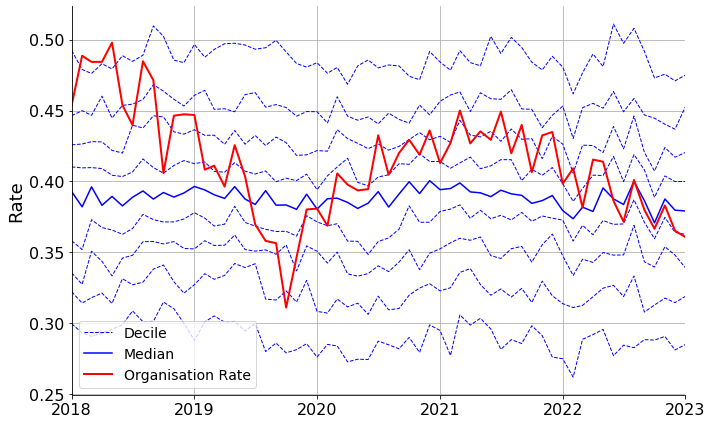

<h2 id=ace><a href=https://openprescribing.net/measure/ace>High-cost Angiotensin-Converting Enzyme (ACE) inhibitors</a></h2>

apply_rate_decrease_filter - Before: 106, After: 95
---------
apply_mean_events_filter - Before: 95, After: 95
---------
apply_zero_filter - Before: 95, After: 95
---------
apply_start_end_percentile_filter - Before: 95, After: 2
---------


<h4><a href=https://openprescribing.net/measure/ace/sicbl/15A>NHS BERKSHIRE WEST</a></h4>

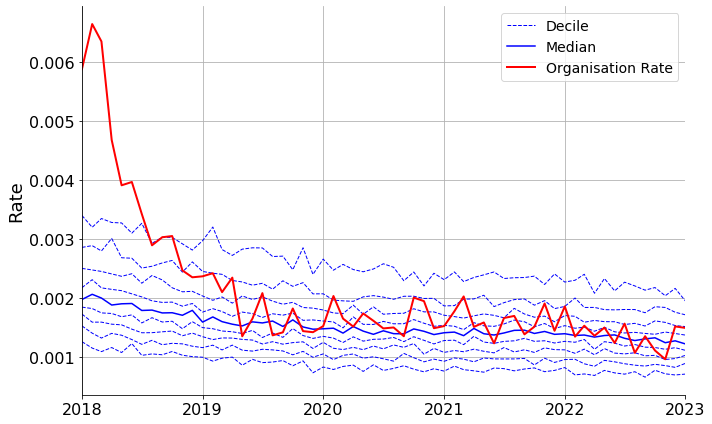

<h4><a href=https://openprescribing.net/measure/ace/sicbl/00Y>NHS OLDHAM</a></h4>

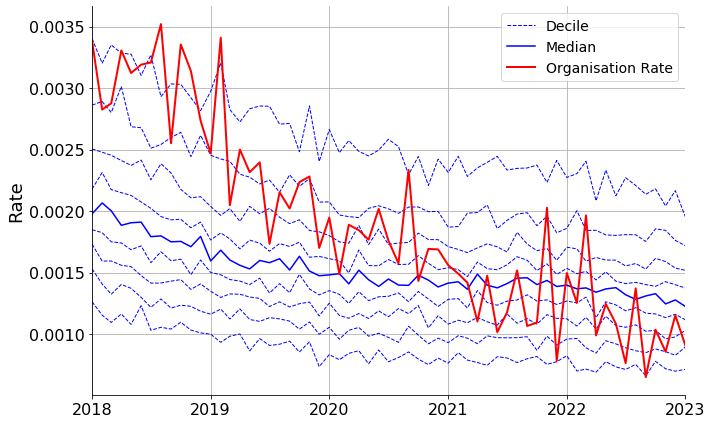

<h2 id=bdzadq><a href=https://openprescribing.net/measure/bdzadq>Anxiolytics and Hypnotics: Average Daily Quantity per item</a></h2>

apply_rate_decrease_filter - Before: 106, After: 100
---------
apply_mean_events_filter - Before: 100, After: 100
---------
apply_zero_filter - Before: 100, After: 100
---------
apply_start_end_percentile_filter - Before: 100, After: 1
---------


<h4><a href=https://openprescribing.net/measure/bdzadq/sicbl/01D>NHS HEYWOOD, MIDDLETON AND ROCHDALE</a></h4>

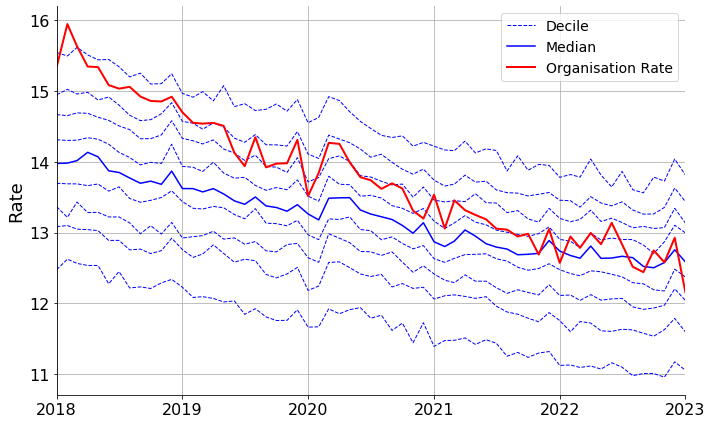

<h2 id=bdzper1000><a href=https://openprescribing.net/measure/bdzper1000>Anxiolytics and Hypnotics: Average Daily Quantity per 1000 patients</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=carbon_salbutamol><a href=https://openprescribing.net/measure/carbon_salbutamol>Environmental impact of inhalers - average carbon footprint per salbutamol inhaler</a></h2>

apply_rate_decrease_filter - Before: 106, After: 87
---------
apply_mean_events_filter - Before: 87, After: 87
---------
apply_zero_filter - Before: 87, After: 87
---------
apply_start_end_percentile_filter - Before: 87, After: 12
---------


<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/06N>NHS HERTS VALLEYS</a></h4>

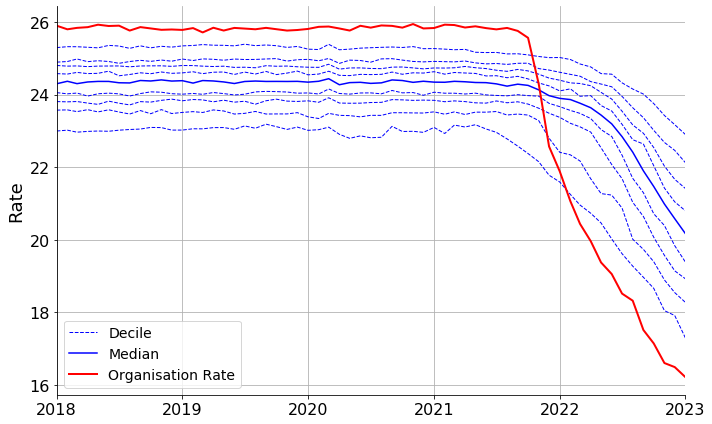

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/D4U1Y>NHS FRIMLEY</a></h4>

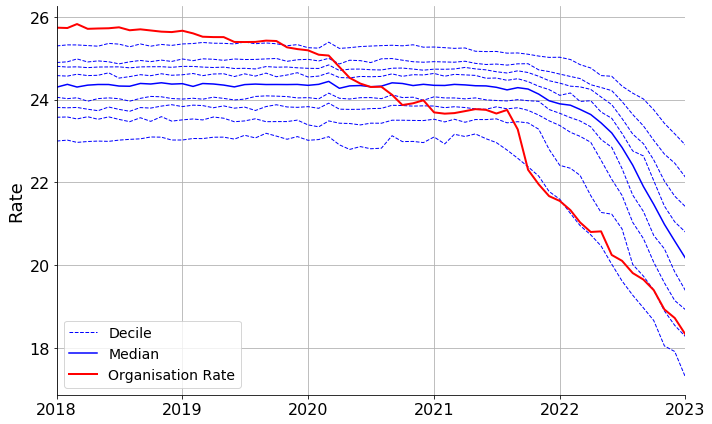

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/05G>NHS NORTH STAFFORDSHIRE</a></h4>

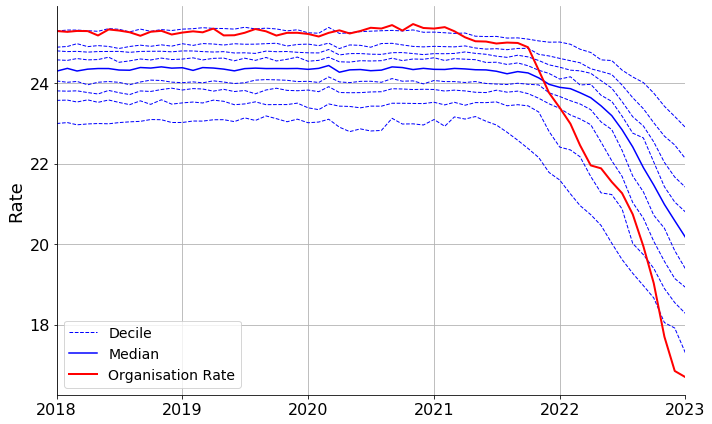

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/27D>NHS CHESHIRE</a></h4>

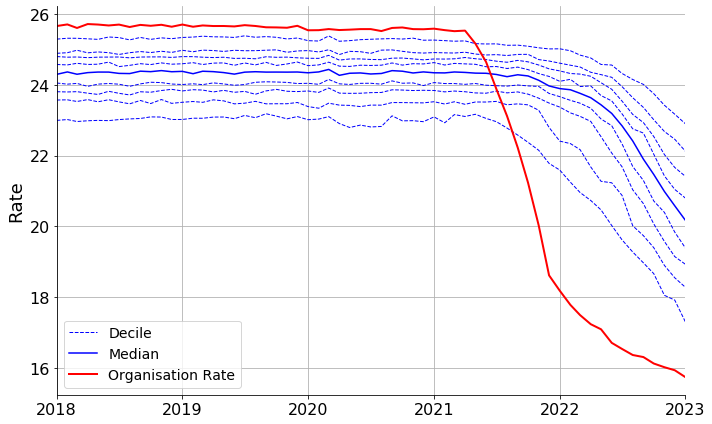

<h4><a href=https://openprescribing.net/measure/carbon_salbutamol/sicbl/15C>NHS BRISTOL, NORTH SOMERSET AND SOUTH GLOUCESTERSHIRE</a></h4>

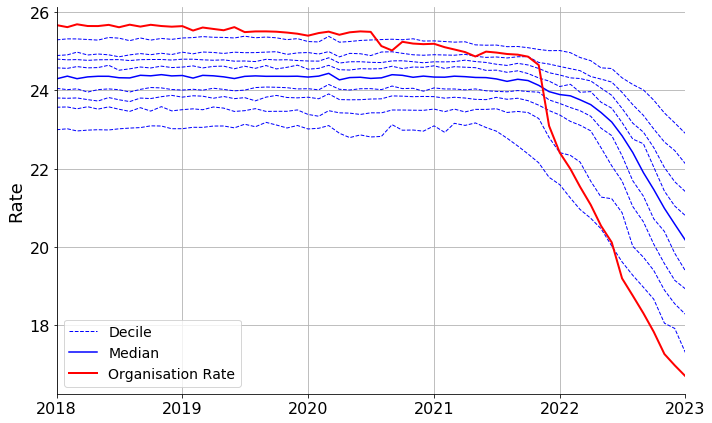

<h2 id=cgm_sensors><a href=https://openprescribing.net/measure/cgm_sensors>Prescribing of continuous glucose monitoring sensors</a></h2>

After applying apply_rate_decrease_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=ciclosporin><a href=https://openprescribing.net/measure/ciclosporin>Ciclosporin and tacrolimus oral preparations prescribed generically</a></h2>

apply_rate_decrease_filter - Before: 106, After: 95
---------
apply_mean_events_filter - Before: 95, After: 4
---------
apply_zero_filter - Before: 4, After: 4
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=cmpaperpt><a href=https://openprescribing.net/measure/cmpaperpt>Cost of milk formulae for Cow's Milk Protein Allergy (CMPA) per listed patients aged 0-4</a></h2>

apply_rate_decrease_filter - Before: 106, After: 10
---------
apply_mean_events_filter - Before: 10, After: 10
---------
apply_zero_filter - Before: 10, After: 10
---------
apply_start_end_percentile_filter - Before: 10, After: 2
---------


<h4><a href=https://openprescribing.net/measure/cmpaperpt/sicbl/99G>NHS SOUTHEND</a></h4>

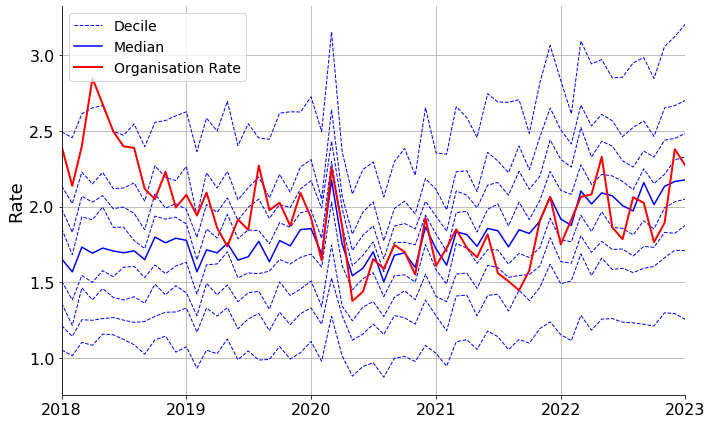

<h4><a href=https://openprescribing.net/measure/cmpaperpt/sicbl/10R>NHS PORTSMOUTH</a></h4>

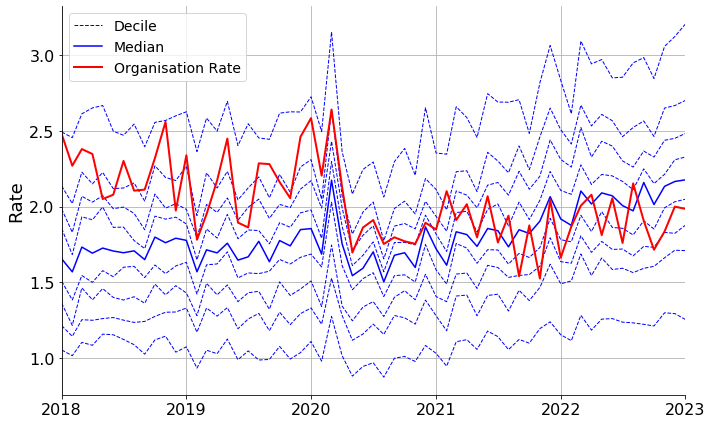

<h2 id=coproxamol><a href=https://openprescribing.net/measure/coproxamol>Co-proxamol</a></h2>

apply_rate_decrease_filter - Before: 106, After: 103
---------
apply_mean_events_filter - Before: 103, After: 1
---------
apply_zero_filter - Before: 1, After: 1
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=desogestrel><a href=https://openprescribing.net/measure/desogestrel>Desogestrel prescribed as a branded product</a></h2>

apply_rate_decrease_filter - Before: 106, After: 100
---------
apply_mean_events_filter - Before: 100, After: 100
---------
apply_zero_filter - Before: 100, After: 100
---------
apply_start_end_percentile_filter - Before: 100, After: 2
---------


<h4><a href=https://openprescribing.net/measure/desogestrel/sicbl/02T>NHS CALDERDALE</a></h4>

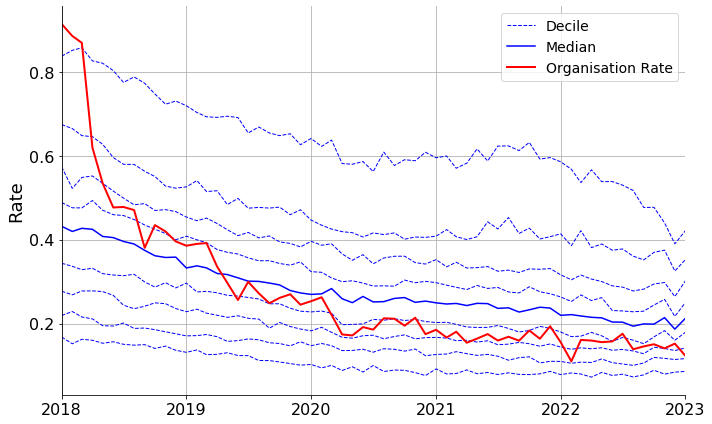

<h4><a href=https://openprescribing.net/measure/desogestrel/sicbl/12F>NHS WIRRAL</a></h4>

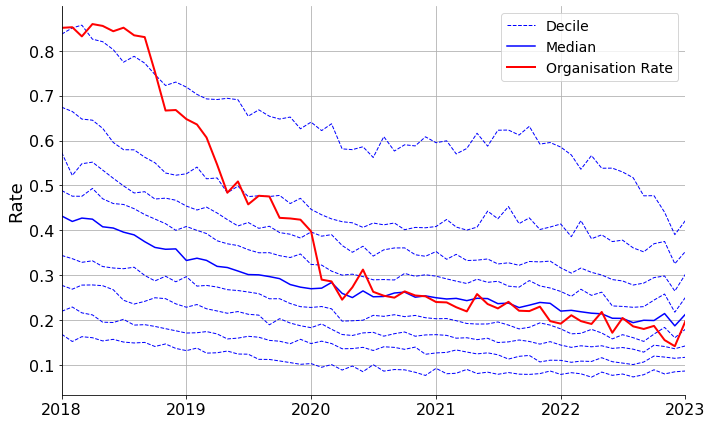

<h2 id=diltiazem><a href=https://openprescribing.net/measure/diltiazem>Diltiazem preparations (>60mg) prescribed generically</a></h2>

apply_rate_decrease_filter - Before: 106, After: 103
---------
apply_mean_events_filter - Before: 103, After: 89
---------
apply_zero_filter - Before: 89, After: 89
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=dipyridamole><a href=https://openprescribing.net/measure/dipyridamole>Prescribing of dipyridamole</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 96
---------
apply_zero_filter - Before: 96, After: 96
---------
apply_start_end_percentile_filter - Before: 96, After: 1
---------


<h4><a href=https://openprescribing.net/measure/dipyridamole/sicbl/01H>NHS NORTH CUMBRIA</a></h4>

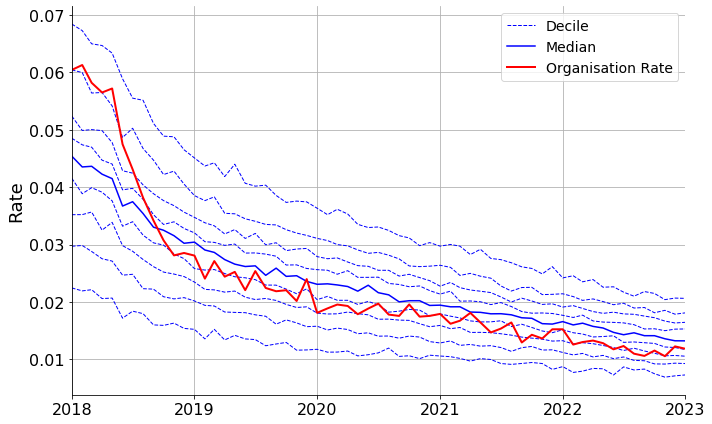

<h2 id=doacs><a href=https://openprescribing.net/measure/doacs>Direct Oral Anticoagulants (DOACs)</a></h2>

After applying apply_rate_decrease_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=edoxaban><a href=https://openprescribing.net/measure/edoxaban>Proportion of Direct Acting Oral Anticoagulants (DOACs) not prescribed as edoxaban</a></h2>

apply_rate_decrease_filter - Before: 106, After: 91
---------
apply_mean_events_filter - Before: 91, After: 91
---------
apply_zero_filter - Before: 91, After: 91
---------
apply_start_end_percentile_filter - Before: 91, After: 1
---------


<h4><a href=https://openprescribing.net/measure/edoxaban/sicbl/02Y>NHS EAST RIDING OF YORKSHIRE</a></h4>

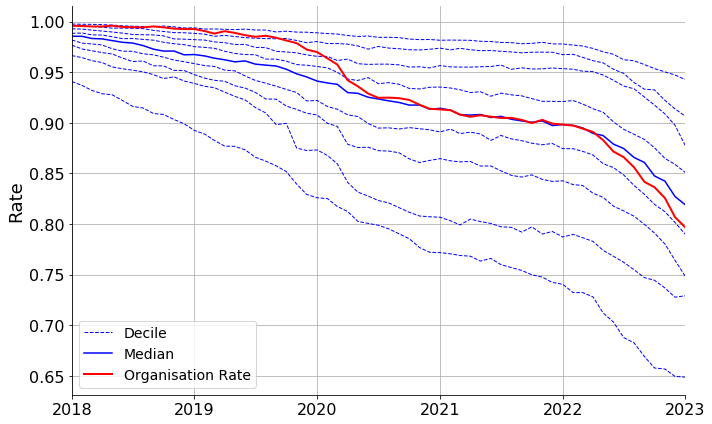

<h2 id=environmental_inhalers><a href=https://openprescribing.net/measure/environmental_inhalers>Environmental impact of inhalers - prescribing of non-salbutamol Metered Dose Inhalers (MDIs)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 1
---------
apply_mean_events_filter - Before: 1, After: 1
---------
apply_zero_filter - Before: 1, After: 1
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=fungal><a href=https://openprescribing.net/measure/fungal>Topical treatment of fungal nail infections</a></h2>

apply_rate_decrease_filter - Before: 106, After: 103
---------
apply_mean_events_filter - Before: 103, After: 73
---------
apply_zero_filter - Before: 73, After: 73
---------
apply_start_end_percentile_filter - Before: 73, After: 1
---------


<h4><a href=https://openprescribing.net/measure/fungal/sicbl/03L>NHS ROTHERHAM</a></h4>

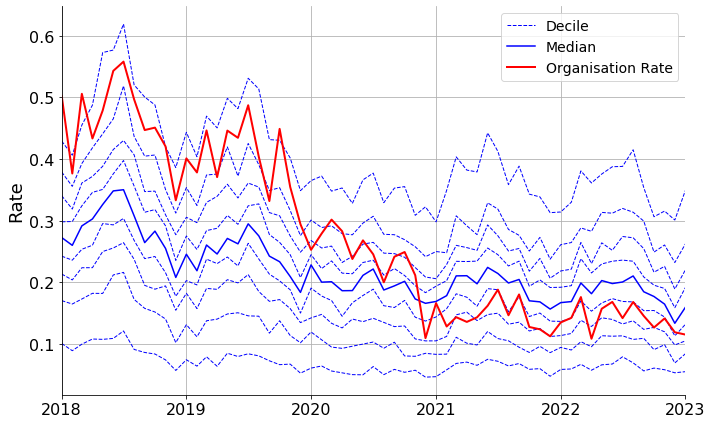

<h2 id=gabapentinoidsddd><a href=https://openprescribing.net/measure/gabapentinoidsddd>Prescribing of gabapentin and pregabalin (DDD)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 5
---------
apply_mean_events_filter - Before: 5, After: 5
---------
apply_zero_filter - Before: 5, After: 5
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=glaucoma><a href=https://openprescribing.net/measure/glaucoma>Glaucoma eye drops prescribed by brand</a></h2>

apply_rate_decrease_filter - Before: 106, After: 11
---------
apply_mean_events_filter - Before: 11, After: 11
---------
apply_zero_filter - Before: 11, After: 11
---------
apply_start_end_percentile_filter - Before: 11, After: 2
---------


<h4><a href=https://openprescribing.net/measure/glaucoma/sicbl/01F>NHS HALTON</a></h4>

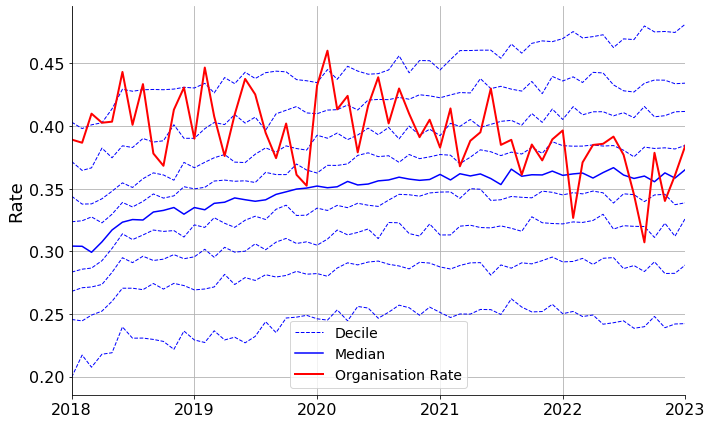

<h4><a href=https://openprescribing.net/measure/glaucoma/sicbl/07G>NHS THURROCK</a></h4>

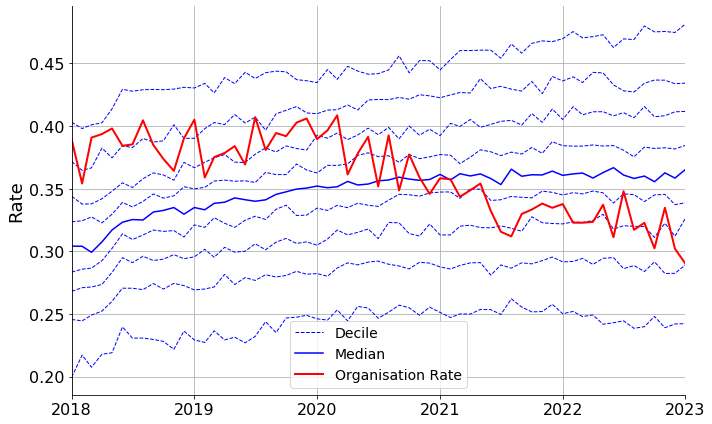

<h2 id=glutenfree><a href=https://openprescribing.net/measure/glutenfree>Prescribing of gluten free products</a></h2>

apply_rate_decrease_filter - Before: 106, After: 97
---------
apply_mean_events_filter - Before: 97, After: 21
---------
apply_zero_filter - Before: 21, After: 2
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=icsdose><a href=https://openprescribing.net/measure/icsdose>High dose inhaled corticosteroids</a></h2>

apply_rate_decrease_filter - Before: 106, After: 102
---------
apply_mean_events_filter - Before: 102, After: 102
---------
apply_zero_filter - Before: 102, After: 102
---------
apply_start_end_percentile_filter - Before: 102, After: 2
---------


<h4><a href=https://openprescribing.net/measure/icsdose/sicbl/00P>NHS SUNDERLAND</a></h4>

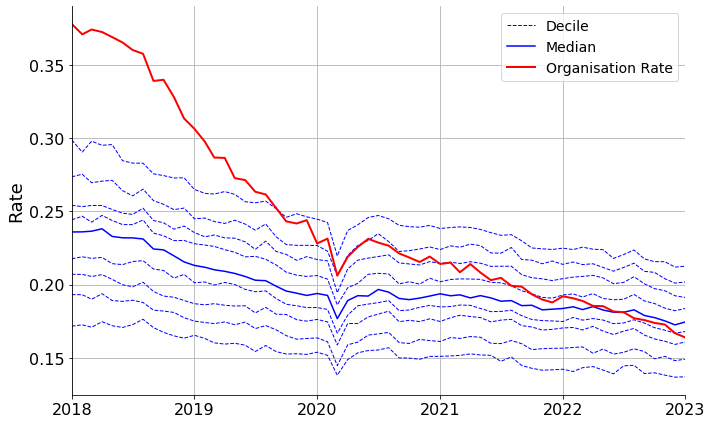

<h4><a href=https://openprescribing.net/measure/icsdose/sicbl/00N>NHS SOUTH TYNESIDE</a></h4>

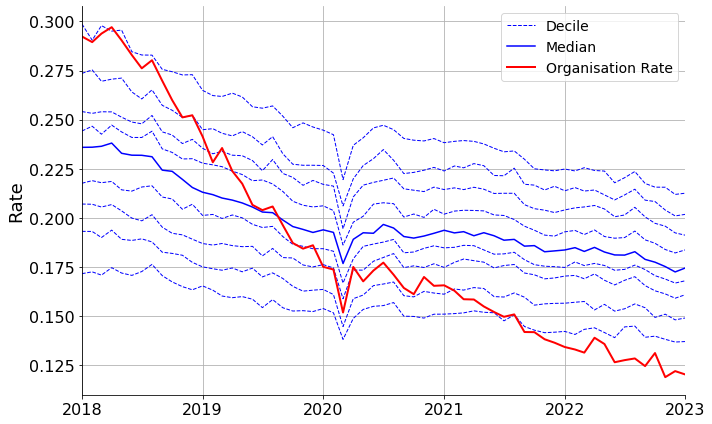

<h2 id=injectable_antibiotics><a href=https://openprescribing.net/measure/injectable_antibiotics>Antibiotic stewardship: Injectable preparations for the treatment of infection</a></h2>

apply_rate_decrease_filter - Before: 106, After: 88
---------
apply_mean_events_filter - Before: 88, After: 1
---------
apply_zero_filter - Before: 1, After: 1
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=keppra><a href=https://openprescribing.net/measure/keppra>Levetiracetam prescribed as Keppra</a></h2>

apply_rate_decrease_filter - Before: 106, After: 94
---------
apply_mean_events_filter - Before: 94, After: 94
---------
apply_zero_filter - Before: 94, After: 94
---------
apply_start_end_percentile_filter - Before: 94, After: 1
---------


<h4><a href=https://openprescribing.net/measure/keppra/sicbl/05W>NHS STOKE ON TRENT</a></h4>

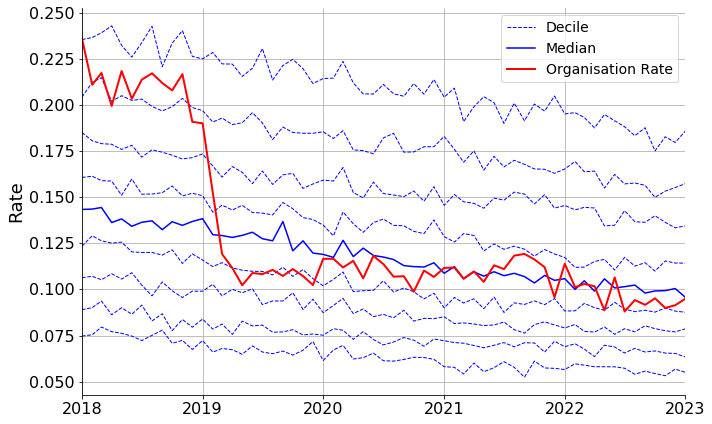

<h2 id=ktt12_diabetes_insulin><a href=https://openprescribing.net/measure/ktt12_diabetes_insulin>Long-acting insulin analogues (KTT12)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 5
---------
apply_mean_events_filter - Before: 5, After: 5
---------
apply_zero_filter - Before: 5, After: 5
---------
apply_start_end_percentile_filter - Before: 5, After: 1
---------


<h4><a href=https://openprescribing.net/measure/ktt12_diabetes_insulin/sicbl/01X>NHS ST HELENS</a></h4>

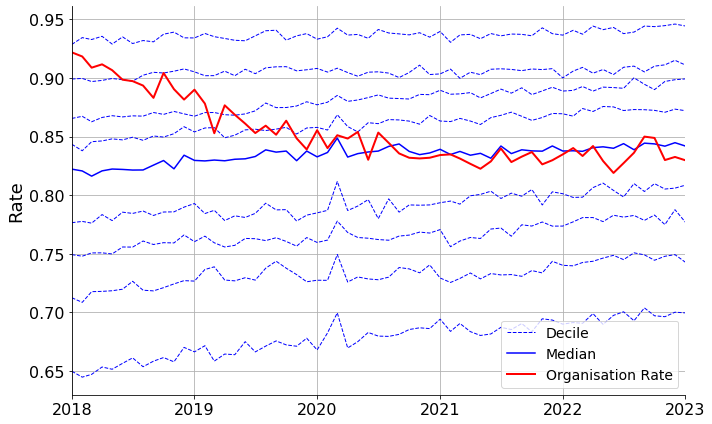

<h2 id=ktt13_nsaids_ibuprofen><a href=https://openprescribing.net/measure/ktt13_nsaids_ibuprofen>Non-preferred NSAIDs and COX-2 inhibitors (KTT13)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 33
---------
apply_mean_events_filter - Before: 33, After: 33
---------
apply_zero_filter - Before: 33, After: 33
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=ktt9_antibiotics><a href=https://openprescribing.net/measure/ktt9_antibiotics>Antibiotic stewardship: volume of antibiotic prescribing (KTT9)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 7
---------
apply_mean_events_filter - Before: 7, After: 7
---------
apply_zero_filter - Before: 7, After: 7
---------
apply_start_end_percentile_filter - Before: 7, After: 3
---------


<h4><a href=https://openprescribing.net/measure/ktt9_antibiotics/sicbl/03K>NHS NORTH LINCOLNSHIRE</a></h4>

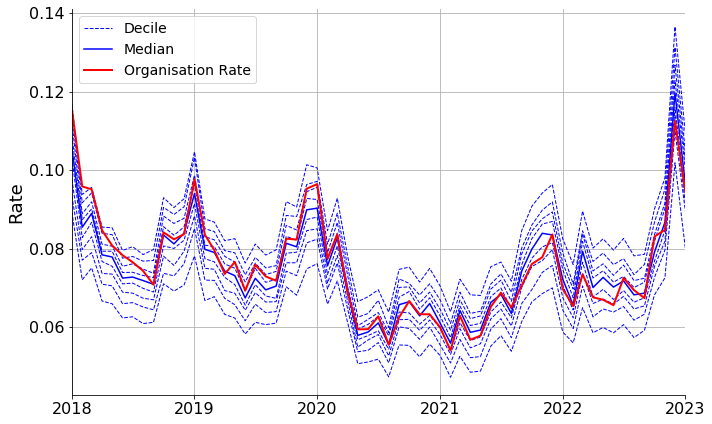

<h4><a href=https://openprescribing.net/measure/ktt9_antibiotics/sicbl/01J>NHS KNOWSLEY</a></h4>

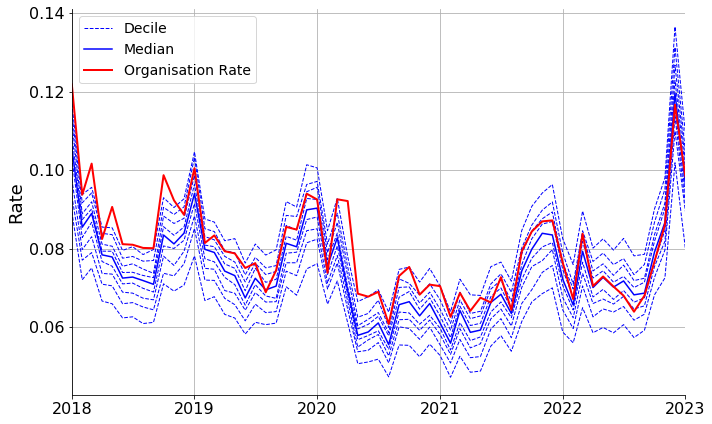

<h4><a href=https://openprescribing.net/measure/ktt9_antibiotics/sicbl/01G>NHS SALFORD</a></h4>

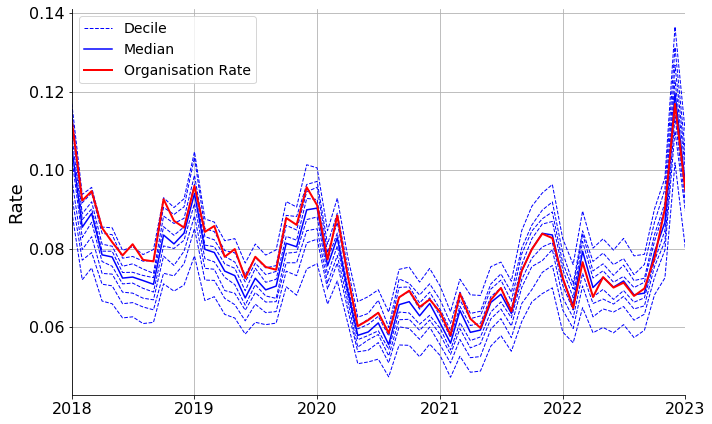

<h2 id=ktt9_cephalosporins><a href=https://openprescribing.net/measure/ktt9_cephalosporins>Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 73
---------
apply_mean_events_filter - Before: 73, After: 73
---------
apply_zero_filter - Before: 73, After: 73
---------
apply_start_end_percentile_filter - Before: 73, After: 3
---------


<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins/sicbl/W2U3Z>NHS NORTH WEST LONDON</a></h4>

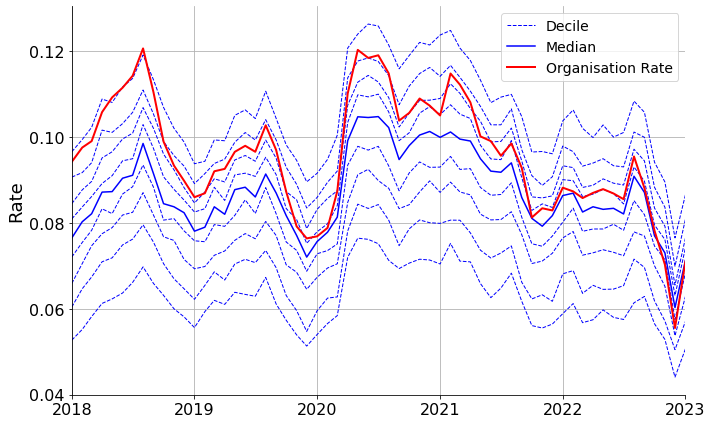

<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins/sicbl/06L>NHS IPSWICH AND EAST SUFFOLK</a></h4>

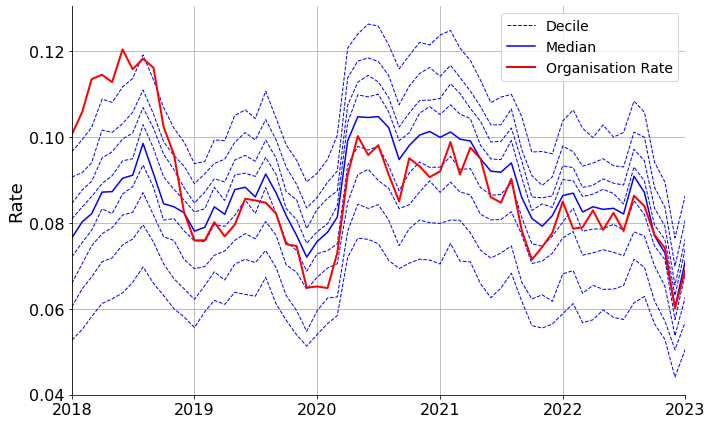

<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

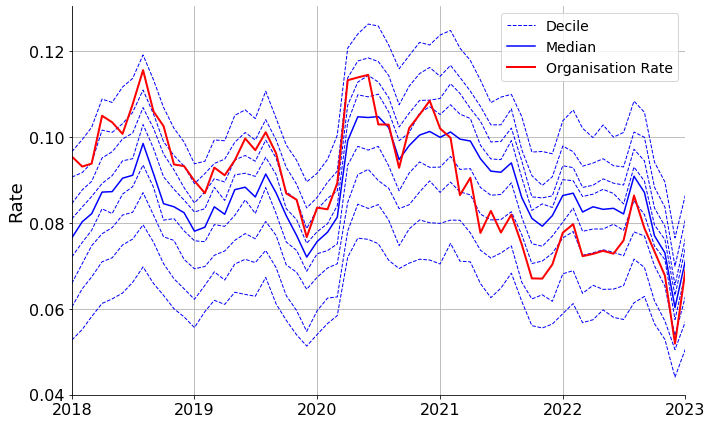

<h2 id=ktt9_cephalosporins_star><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star>Antibiotic stewardship: co-amoxiclav, cephalosporins & quinolones (KTT9) prescribing volume</a></h2>

apply_rate_decrease_filter - Before: 106, After: 62
---------
apply_mean_events_filter - Before: 62, After: 62
---------
apply_zero_filter - Before: 62, After: 62
---------
apply_start_end_percentile_filter - Before: 62, After: 3
---------


<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star/sicbl/00Y>NHS OLDHAM</a></h4>

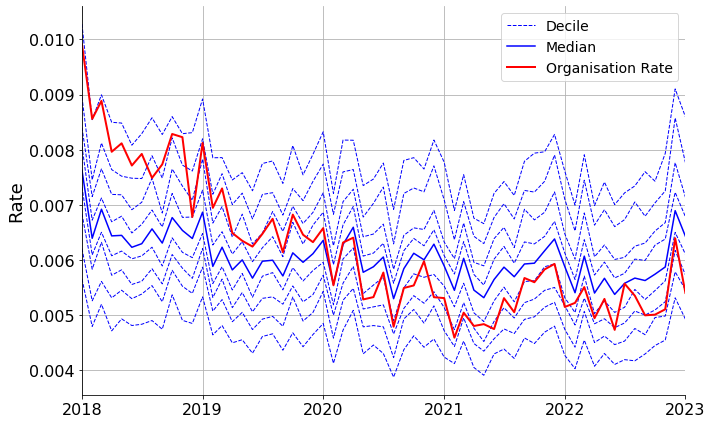

<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star/sicbl/00P>NHS SUNDERLAND</a></h4>

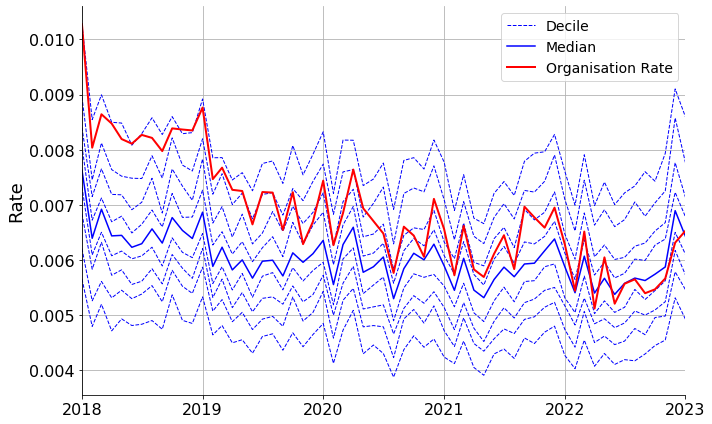

<h4><a href=https://openprescribing.net/measure/ktt9_cephalosporins_star/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

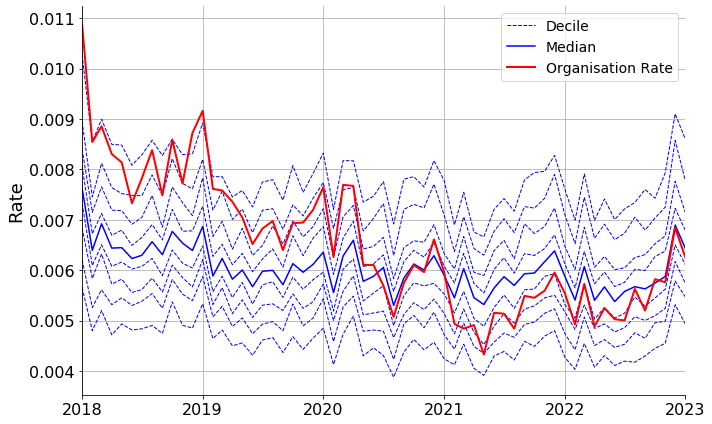

<h2 id=lpaliskiren><a href=https://openprescribing.net/measure/lpaliskiren>NHS England Low Priority Treatment - Aliskiren</a></h2>

apply_rate_decrease_filter - Before: 106, After: 101
---------
apply_mean_events_filter - Before: 101, After: 93
---------
apply_zero_filter - Before: 93, After: 93
---------
apply_start_end_percentile_filter - Before: 93, After: 1
---------


<h4><a href=https://openprescribing.net/measure/lpaliskiren/sicbl/04Y>NHS CANNOCK CHASE</a></h4>

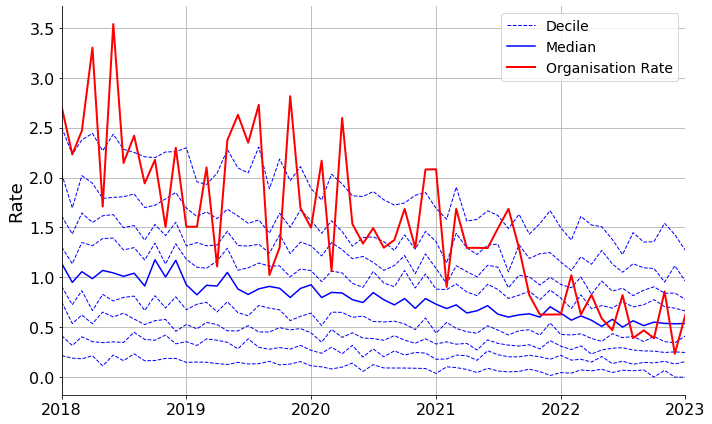

<h2 id=lpamiodarone><a href=https://openprescribing.net/measure/lpamiodarone>NHS England Low Priority Treatment - Amiodarone</a></h2>

apply_rate_decrease_filter - Before: 106, After: 103
---------
apply_mean_events_filter - Before: 103, After: 103
---------
apply_zero_filter - Before: 103, After: 103
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpbathshoweremollients><a href=https://openprescribing.net/measure/lpbathshoweremollients>NHS England Low Priority Treatment - Bath and Shower emollients</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpbathshoweremollients/sicbl/00T>NHS BOLTON</a></h4>

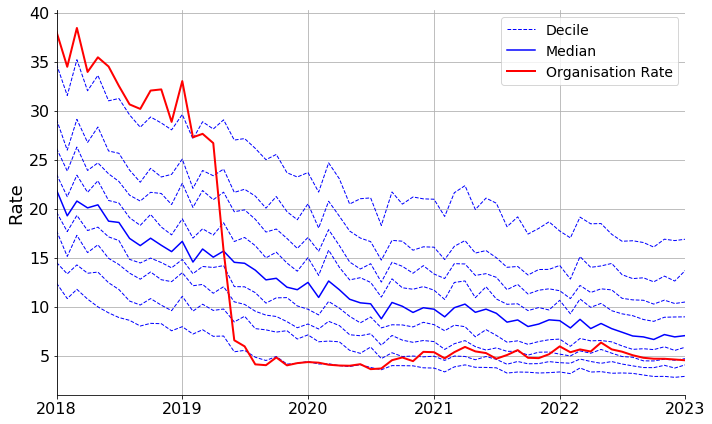

<h4><a href=https://openprescribing.net/measure/lpbathshoweremollients/sicbl/01G>NHS SALFORD</a></h4>

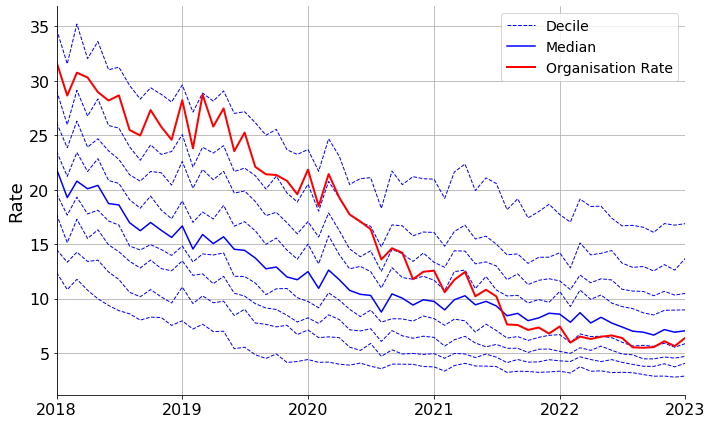

<h2 id=lpcoprox><a href=https://openprescribing.net/measure/lpcoprox>NHS England Low Priority Treatment - co-proxamol</a></h2>

apply_rate_decrease_filter - Before: 106, After: 94
---------
apply_mean_events_filter - Before: 94, After: 91
---------
apply_zero_filter - Before: 91, After: 79
---------
apply_start_end_percentile_filter - Before: 79, After: 3
---------


<h4><a href=https://openprescribing.net/measure/lpcoprox/sicbl/13T>NHS NEWCASTLE GATESHEAD</a></h4>

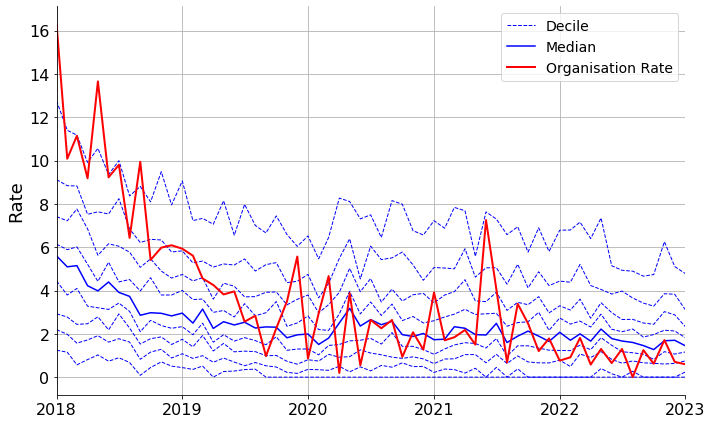

<h4><a href=https://openprescribing.net/measure/lpcoprox/sicbl/05V>NHS STAFFORD AND SURROUNDS</a></h4>

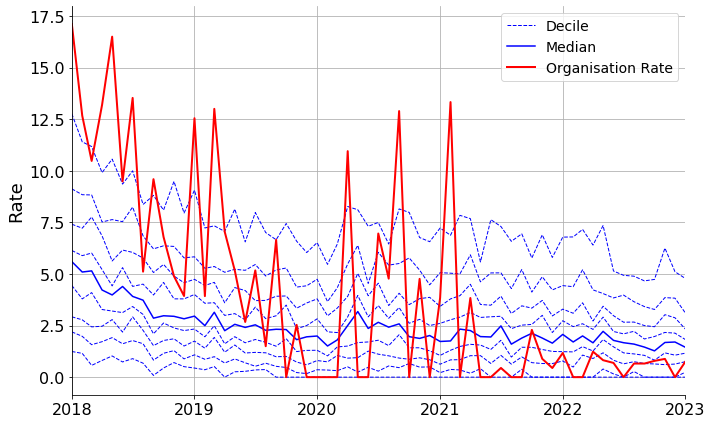

<h4><a href=https://openprescribing.net/measure/lpcoprox/sicbl/00P>NHS SUNDERLAND</a></h4>

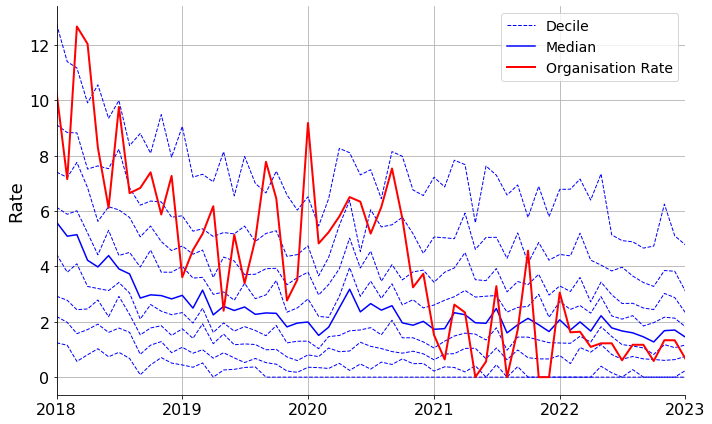

<h2 id=lpdosulepin><a href=https://openprescribing.net/measure/lpdosulepin>NHS England Low Priority Treatment - dosulepin</a></h2>

After applying apply_rate_decrease_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpdoxazosin><a href=https://openprescribing.net/measure/lpdoxazosin>NHS England Low Priority Treatment - doxazosin modified release</a></h2>

apply_rate_decrease_filter - Before: 106, After: 103
---------
apply_mean_events_filter - Before: 103, After: 103
---------
apply_zero_filter - Before: 103, After: 103
---------
apply_start_end_percentile_filter - Before: 103, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpdoxazosin/sicbl/00V>NHS BURY</a></h4>

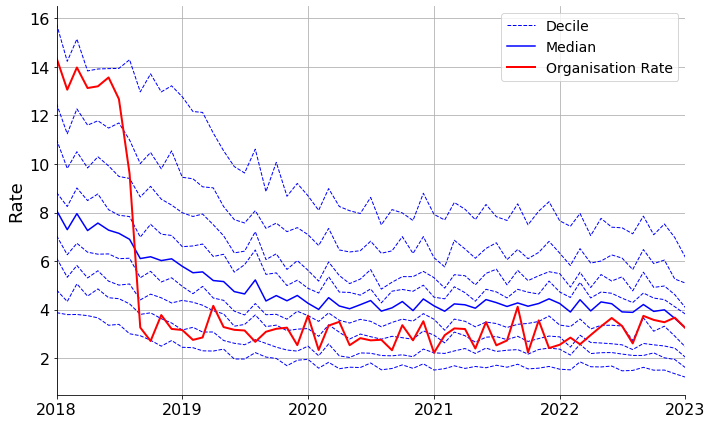

<h4><a href=https://openprescribing.net/measure/lpdoxazosin/sicbl/00Y>NHS OLDHAM</a></h4>

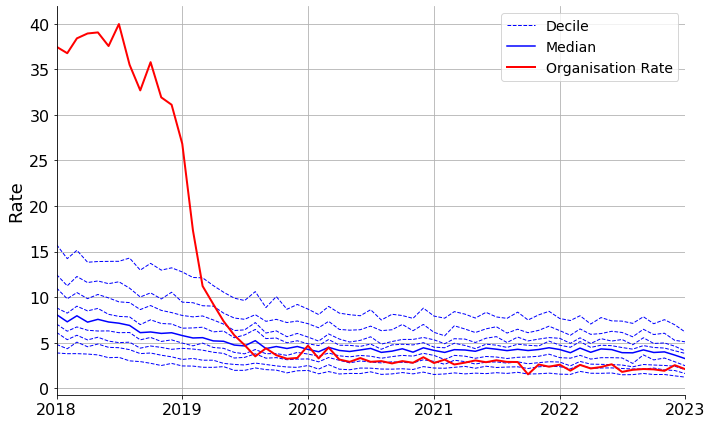

<h2 id=lpdronedarone><a href=https://openprescribing.net/measure/lpdronedarone>NHS England Low Priority Treatment - Dronedarone</a></h2>

apply_rate_decrease_filter - Before: 106, After: 77
---------
apply_mean_events_filter - Before: 77, After: 73
---------
apply_zero_filter - Before: 73, After: 71
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpfentanylir><a href=https://openprescribing.net/measure/lpfentanylir>NHS England Low Priority Treatment - fentanyl immediate release</a></h2>

apply_rate_decrease_filter - Before: 106, After: 90
---------
apply_mean_events_filter - Before: 90, After: 88
---------
apply_zero_filter - Before: 88, After: 81
---------
apply_start_end_percentile_filter - Before: 81, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpfentanylir/sicbl/99C>NHS NORTH TYNESIDE</a></h4>

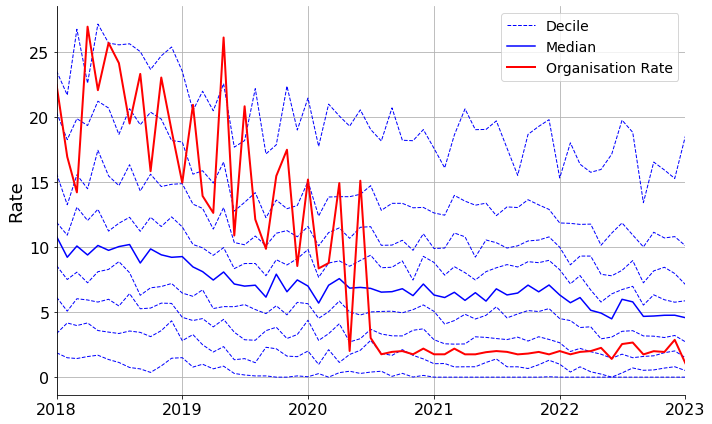

<h4><a href=https://openprescribing.net/measure/lpfentanylir/sicbl/05Q>NHS SOUTH EAST STAFFORDSHIRE AND SEISDON PENINSULA</a></h4>

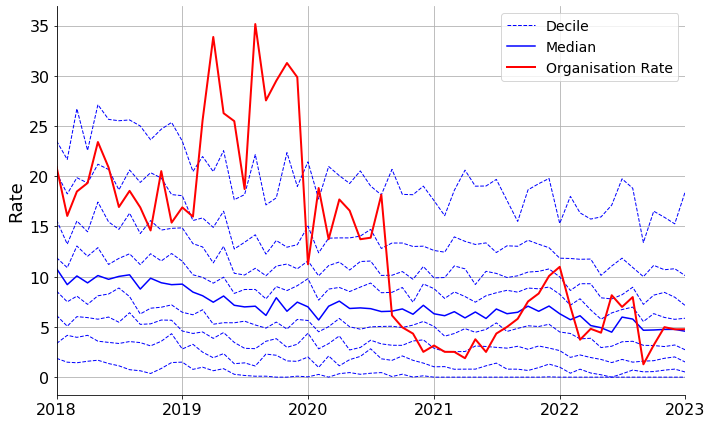

<h2 id=lpglucosamine><a href=https://openprescribing.net/measure/lpglucosamine>NHS England Low Priority Treatment - glucosamine and chondroitin</a></h2>

apply_rate_decrease_filter - Before: 106, After: 82
---------
apply_mean_events_filter - Before: 82, After: 33
---------
apply_zero_filter - Before: 33, After: 31
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpherbal><a href=https://openprescribing.net/measure/lpherbal>NHS England Low Priority Treatment - herbal medicines</a></h2>

apply_rate_decrease_filter - Before: 106, After: 52
---------
apply_mean_events_filter - Before: 52, After: 10
---------
apply_zero_filter - Before: 10, After: 10
---------
apply_start_end_percentile_filter - Before: 10, After: 1
---------


<h4><a href=https://openprescribing.net/measure/lpherbal/sicbl/06T>NHS NORTH EAST ESSEX</a></h4>

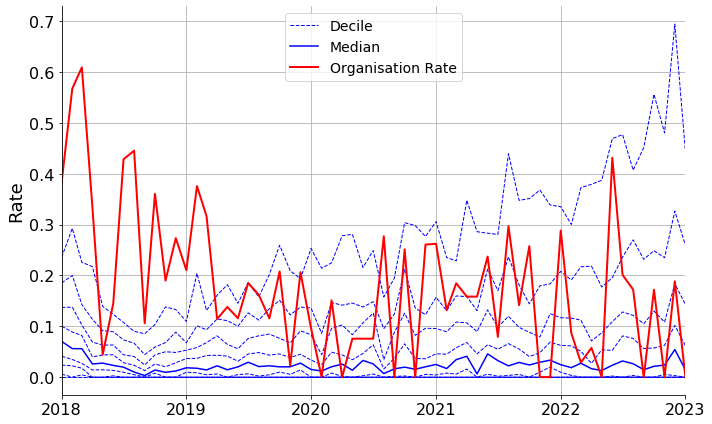

<h2 id=lphomeopathy><a href=https://openprescribing.net/measure/lphomeopathy>NHS England Low Priority Treatment - homeopathy</a></h2>

apply_rate_decrease_filter - Before: 106, After: 89
---------
apply_mean_events_filter - Before: 89, After: 5
---------
apply_zero_filter - Before: 5, After: 5
---------
apply_start_end_percentile_filter - Before: 5, After: 1
---------


<h4><a href=https://openprescribing.net/measure/lphomeopathy/sicbl/15C>NHS BRISTOL, NORTH SOMERSET AND SOUTH GLOUCESTERSHIRE</a></h4>

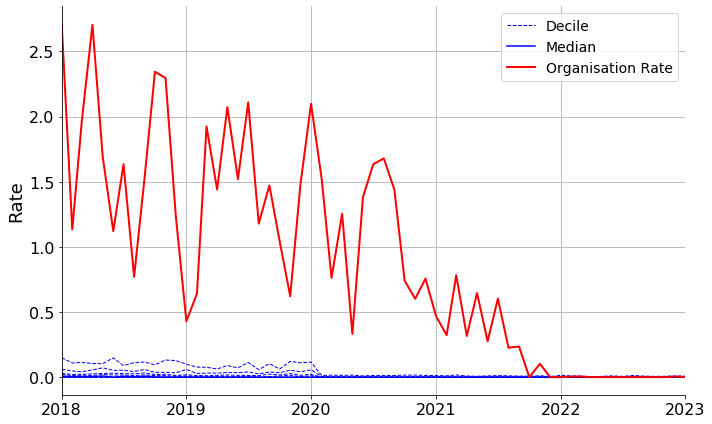

<h2 id=lplidocaine><a href=https://openprescribing.net/measure/lplidocaine>NHS England Low Priority Treatment - lidocaine plasters</a></h2>

apply_rate_decrease_filter - Before: 106, After: 77
---------
apply_mean_events_filter - Before: 77, After: 77
---------
apply_zero_filter - Before: 77, After: 77
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpliothyronine><a href=https://openprescribing.net/measure/lpliothyronine>NHS England Low Priority Treatment - liothyronine (including Armour Thyroid and liothyronine combination products)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 104
---------
apply_mean_events_filter - Before: 104, After: 104
---------
apply_zero_filter - Before: 104, After: 104
---------
apply_start_end_percentile_filter - Before: 104, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpliothyronine/sicbl/01F>NHS HALTON</a></h4>

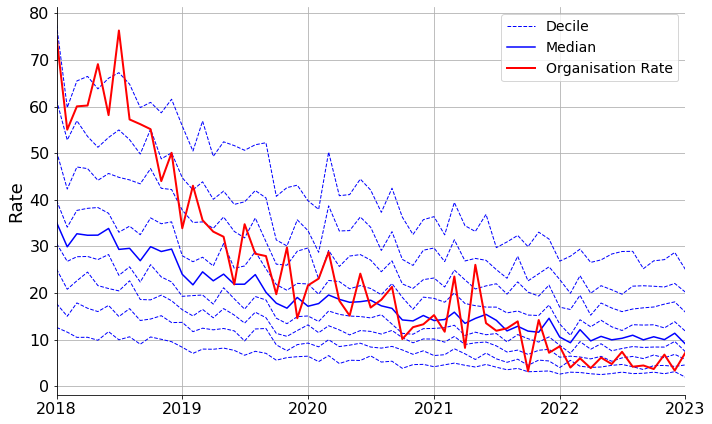

<h4><a href=https://openprescribing.net/measure/lpliothyronine/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

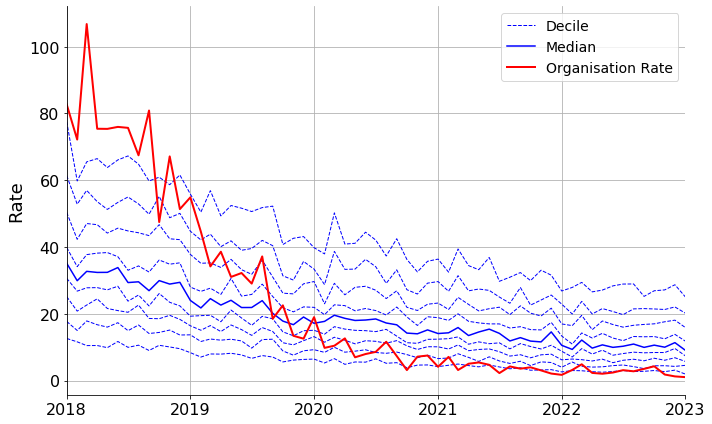

<h2 id=lplutein><a href=https://openprescribing.net/measure/lplutein>NHS England Low Priority Treatment - lutein and antioxidants</a></h2>

apply_rate_decrease_filter - Before: 106, After: 104
---------
apply_mean_events_filter - Before: 104, After: 81
---------
apply_zero_filter - Before: 81, After: 81
---------
apply_start_end_percentile_filter - Before: 81, After: 4
---------


<h4><a href=https://openprescribing.net/measure/lplutein/sicbl/06K>NHS EAST AND NORTH HERTFORDSHIRE</a></h4>

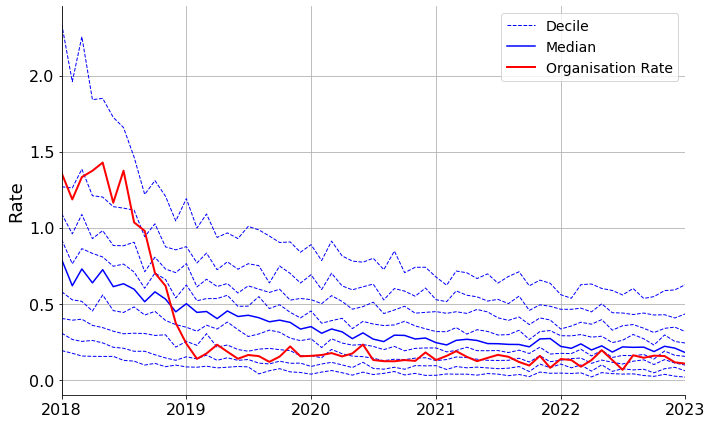

<h4><a href=https://openprescribing.net/measure/lplutein/sicbl/D4U1Y>NHS FRIMLEY</a></h4>

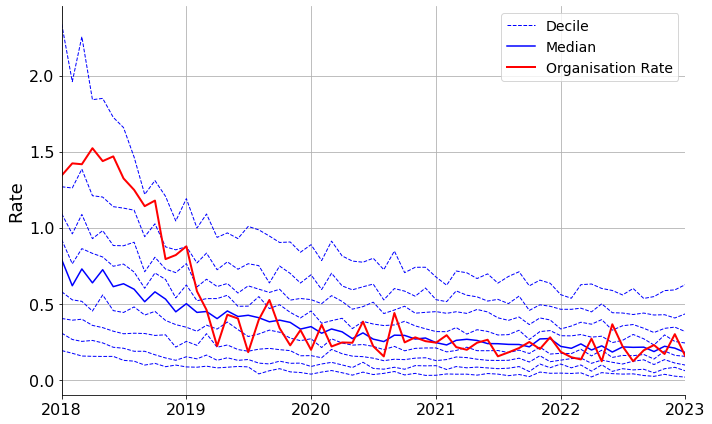

<h4><a href=https://openprescribing.net/measure/lplutein/sicbl/05W>NHS STOKE ON TRENT</a></h4>

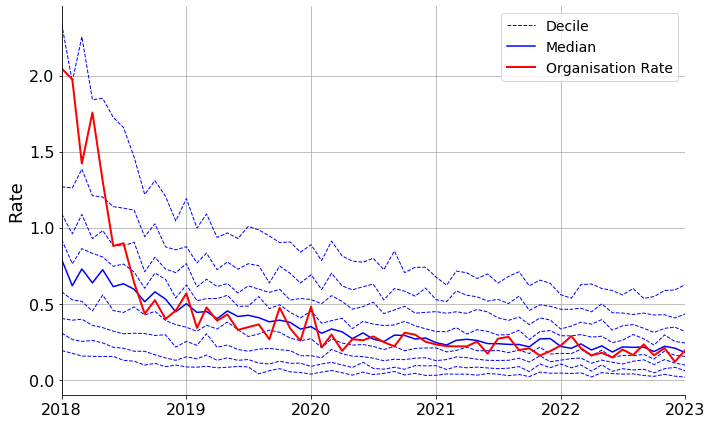

<h4><a href=https://openprescribing.net/measure/lplutein/sicbl/02Y>NHS EAST RIDING OF YORKSHIRE</a></h4>

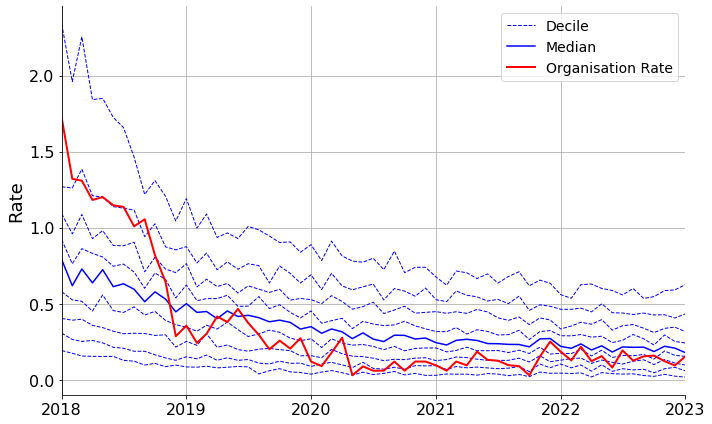

<h2 id=lpminocycline><a href=https://openprescribing.net/measure/lpminocycline>NHS England Low Priority Treatment - Minocycline</a></h2>

apply_rate_decrease_filter - Before: 106, After: 105
---------
apply_mean_events_filter - Before: 105, After: 101
---------
apply_zero_filter - Before: 101, After: 101
---------
apply_start_end_percentile_filter - Before: 101, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpminocycline/sicbl/06H>NHS CAMBRIDGESHIRE AND PETERBOROUGH</a></h4>

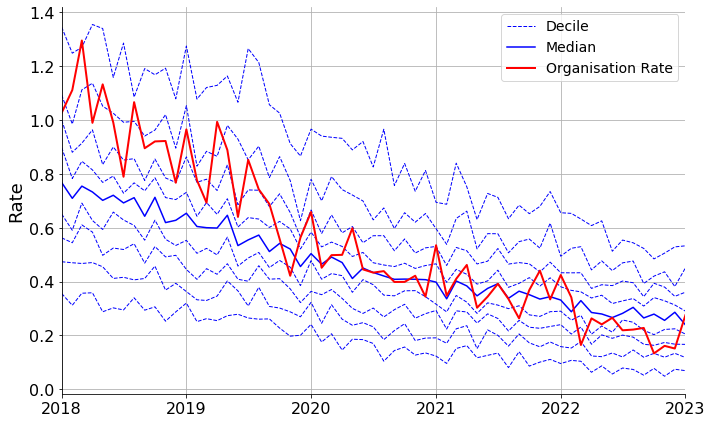

<h4><a href=https://openprescribing.net/measure/lpminocycline/sicbl/00X>NHS CHORLEY AND SOUTH RIBBLE</a></h4>

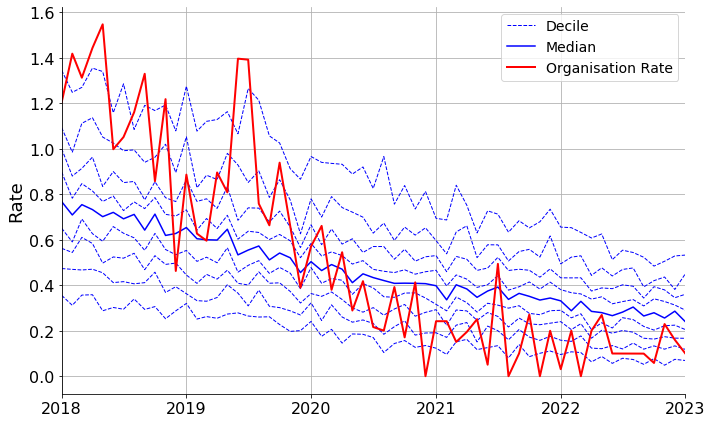

<h2 id=lpneedles><a href=https://openprescribing.net/measure/lpneedles>NHS England Low Priority Treatment - Higher Cost Insulin Pen Needles</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpneedles/sicbl/00R>NHS BLACKPOOL</a></h4>

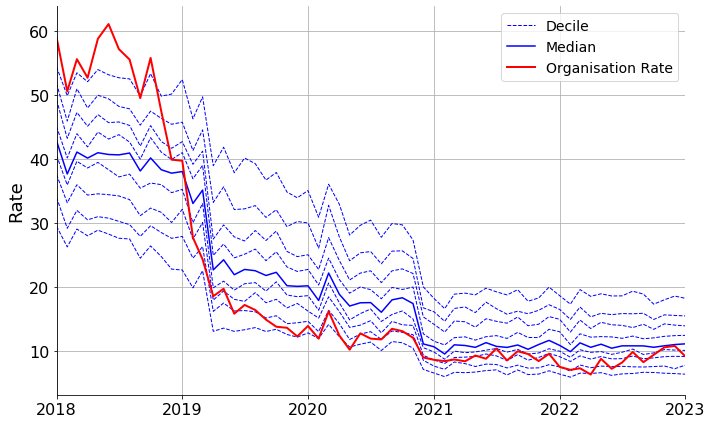

<h4><a href=https://openprescribing.net/measure/lpneedles/sicbl/02P>NHS BARNSLEY</a></h4>

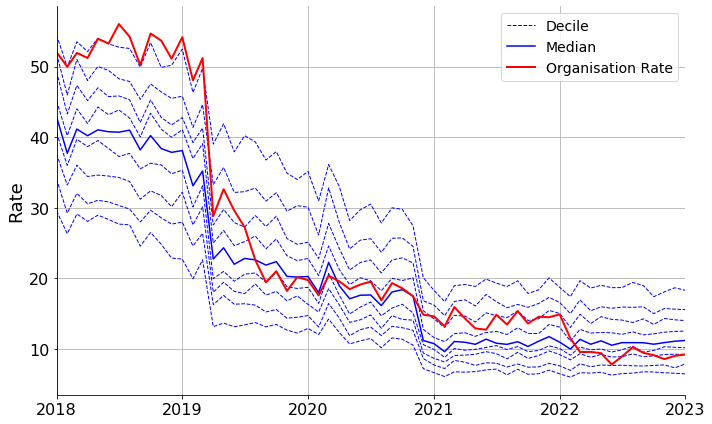

<h2 id=lpomega3><a href=https://openprescribing.net/measure/lpomega3>NHS England Low Priority Treatment - omega-3 fatty acid compounds</a></h2>

apply_rate_decrease_filter - Before: 106, After: 97
---------
apply_mean_events_filter - Before: 97, After: 97
---------
apply_zero_filter - Before: 97, After: 97
---------
apply_start_end_percentile_filter - Before: 97, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpomega3/sicbl/07G>NHS THURROCK</a></h4>

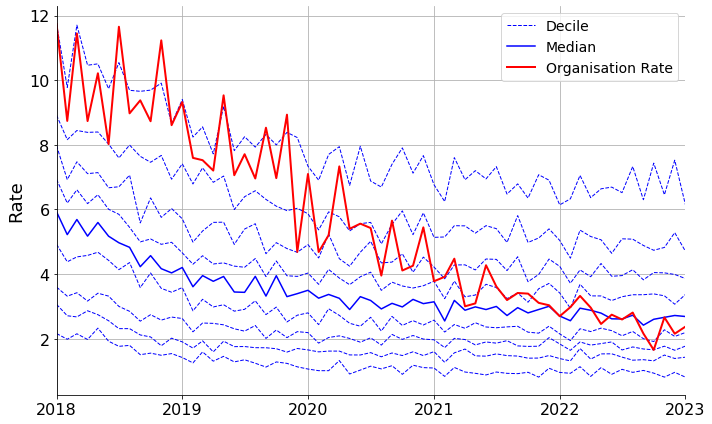

<h4><a href=https://openprescribing.net/measure/lpomega3/sicbl/06T>NHS NORTH EAST ESSEX</a></h4>

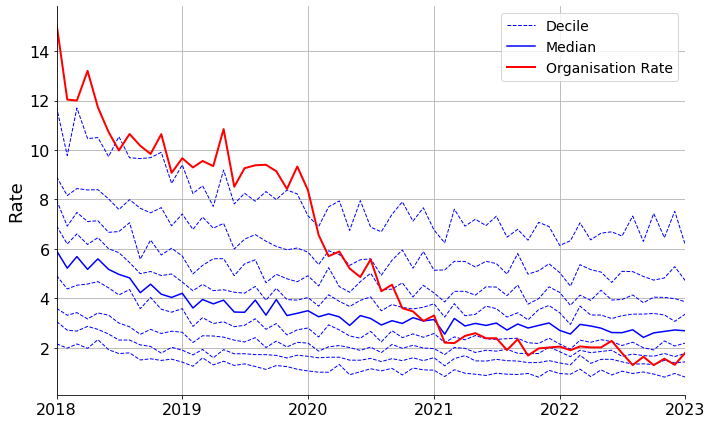

<h2 id=lpoxycodone><a href=https://openprescribing.net/measure/lpoxycodone>NHS England Low Priority Treatment - oxycodone and naloxone combination product</a></h2>

apply_rate_decrease_filter - Before: 106, After: 98
---------
apply_mean_events_filter - Before: 98, After: 98
---------
apply_zero_filter - Before: 98, After: 98
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lpperindopril><a href=https://openprescribing.net/measure/lpperindopril>NHS England Low Priority Treatment - perindopril arginine</a></h2>

apply_rate_decrease_filter - Before: 106, After: 91
---------
apply_mean_events_filter - Before: 91, After: 91
---------
apply_zero_filter - Before: 91, After: 91
---------
apply_start_end_percentile_filter - Before: 91, After: 4
---------


<h4><a href=https://openprescribing.net/measure/lpperindopril/sicbl/15A>NHS BERKSHIRE WEST</a></h4>

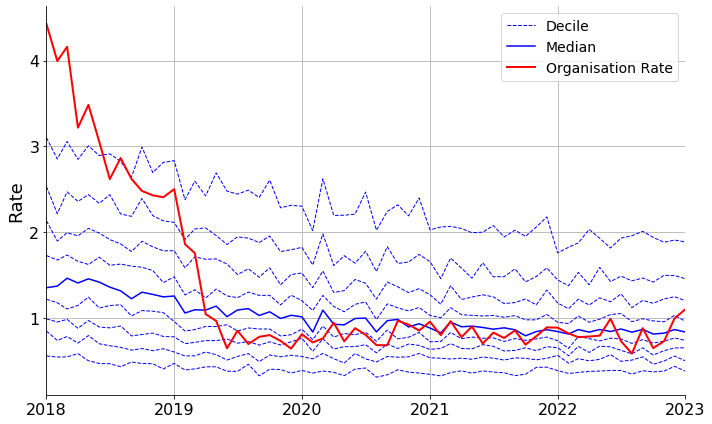

<h4><a href=https://openprescribing.net/measure/lpperindopril/sicbl/02P>NHS BARNSLEY</a></h4>

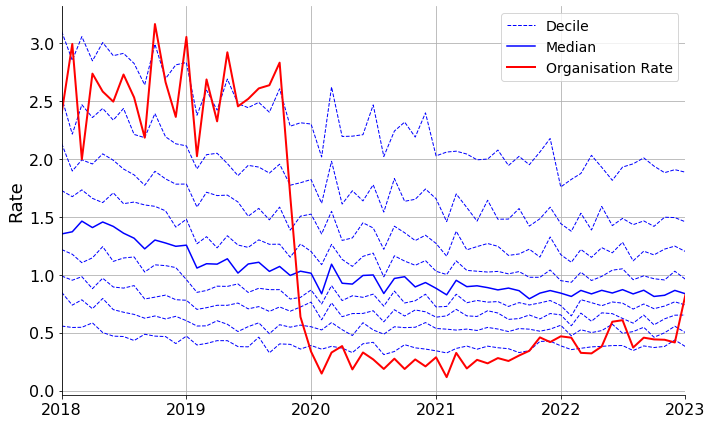

<h4><a href=https://openprescribing.net/measure/lpperindopril/sicbl/02T>NHS CALDERDALE</a></h4>

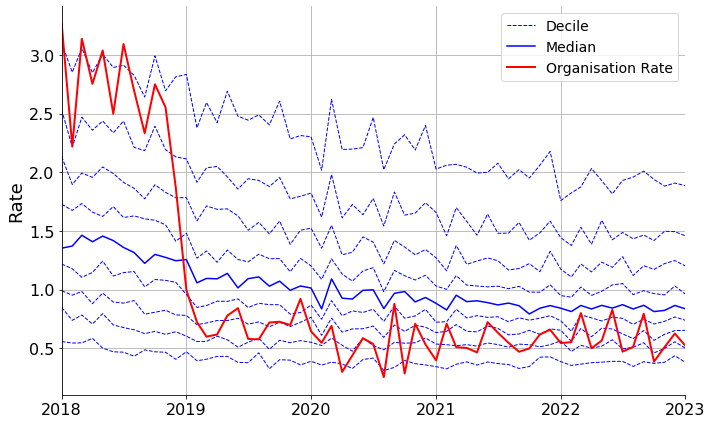

<h4><a href=https://openprescribing.net/measure/lpperindopril/sicbl/D4U1Y>NHS FRIMLEY</a></h4>

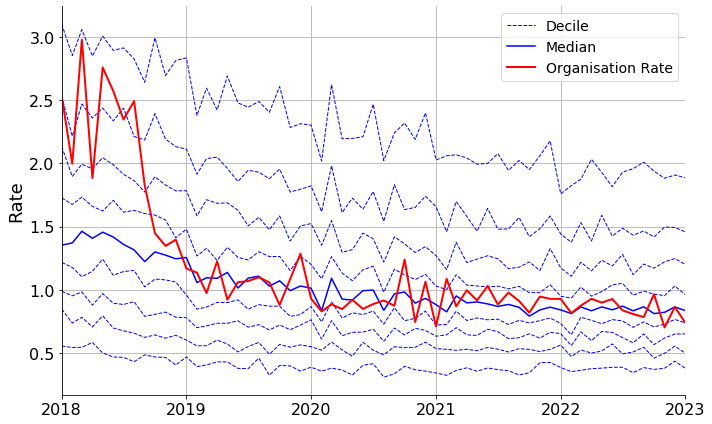

<h2 id=lprubefacients><a href=https://openprescribing.net/measure/lprubefacients>NHS England Low Priority Treatment - rubefacients</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 3
---------


<h4><a href=https://openprescribing.net/measure/lprubefacients/sicbl/01X>NHS ST HELENS</a></h4>

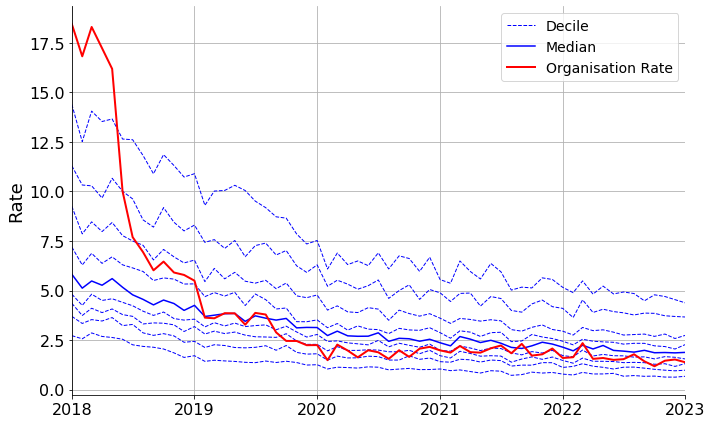

<h4><a href=https://openprescribing.net/measure/lprubefacients/sicbl/01V>NHS SOUTHPORT AND FORMBY</a></h4>

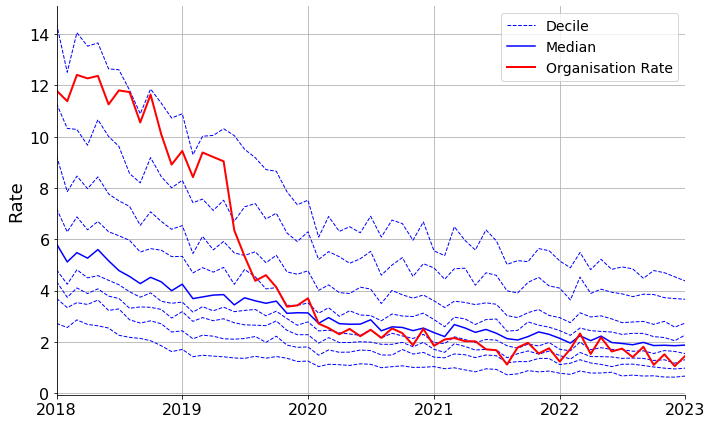

<h4><a href=https://openprescribing.net/measure/lprubefacients/sicbl/02P>NHS BARNSLEY</a></h4>

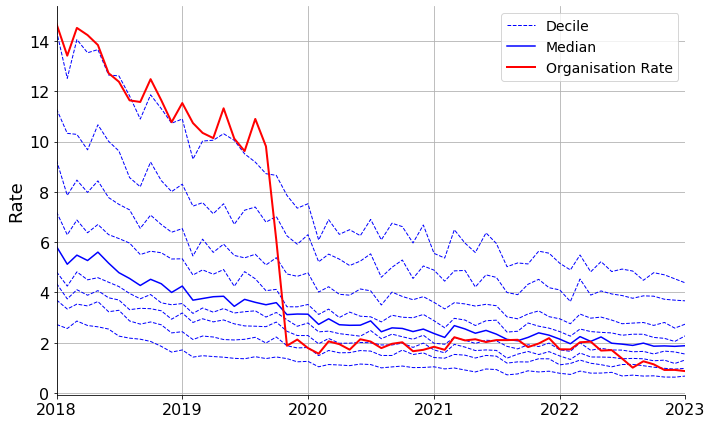

<h2 id=lpsilkgarments><a href=https://openprescribing.net/measure/lpsilkgarments>NHS England Low Priority Treatment - Silk Garments</a></h2>

apply_rate_decrease_filter - Before: 106, After: 98
---------
apply_mean_events_filter - Before: 98, After: 91
---------
apply_zero_filter - Before: 91, After: 88
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lptadalafil><a href=https://openprescribing.net/measure/lptadalafil>NHS England Low Priority Treatment - tadalafil once daily</a></h2>

apply_rate_decrease_filter - Before: 106, After: 105
---------
apply_mean_events_filter - Before: 105, After: 105
---------
apply_zero_filter - Before: 105, After: 105
---------
apply_start_end_percentile_filter - Before: 105, After: 1
---------


<h4><a href=https://openprescribing.net/measure/lptadalafil/sicbl/03L>NHS ROTHERHAM</a></h4>

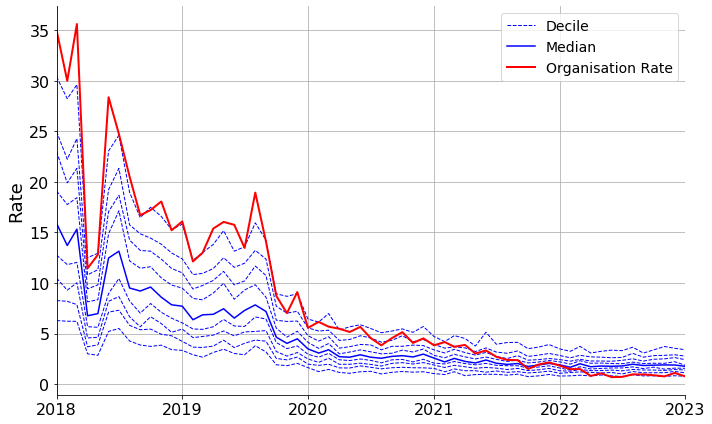

<h2 id=lptramadolpara><a href=https://openprescribing.net/measure/lptramadolpara>NHS England Low Priority Treatment - paracetamol and tramadol combination</a></h2>

apply_rate_decrease_filter - Before: 106, After: 104
---------
apply_mean_events_filter - Before: 104, After: 92
---------
apply_zero_filter - Before: 92, After: 92
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=lptravelvacs><a href=https://openprescribing.net/measure/lptravelvacs>NHS England Low Priority Treatment - travel vaccines</a></h2>

apply_rate_decrease_filter - Before: 106, After: 97
---------
apply_mean_events_filter - Before: 97, After: 97
---------
apply_zero_filter - Before: 97, After: 97
---------
apply_start_end_percentile_filter - Before: 97, After: 3
---------


<h4><a href=https://openprescribing.net/measure/lptravelvacs/sicbl/05W>NHS STOKE ON TRENT</a></h4>

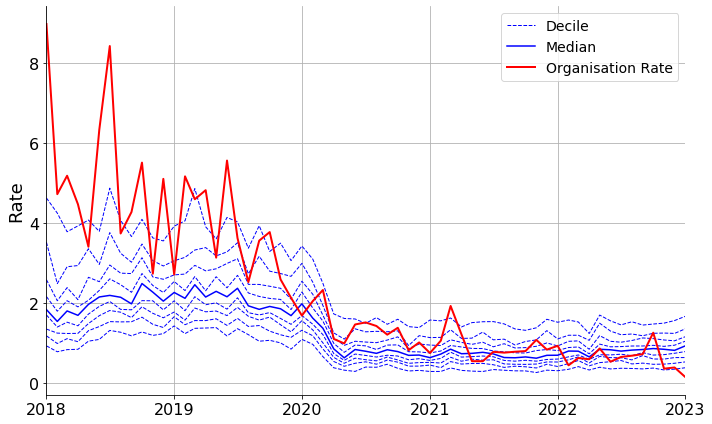

<h4><a href=https://openprescribing.net/measure/lptravelvacs/sicbl/10Q>NHS OXFORDSHIRE</a></h4>

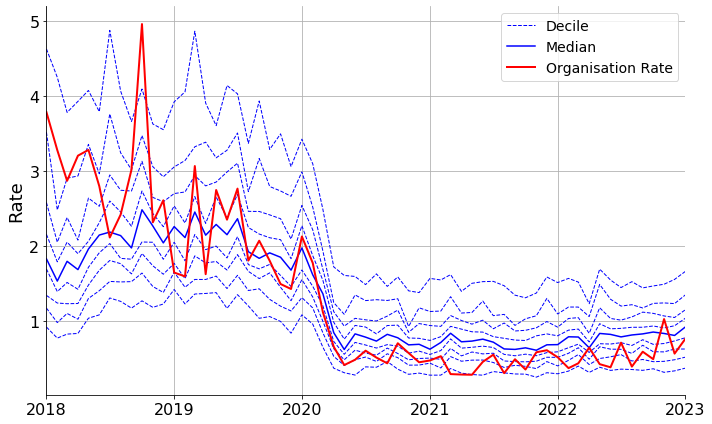

<h4><a href=https://openprescribing.net/measure/lptravelvacs/sicbl/B2M3M>NHS COVENTRY AND WARWICKSHIRE</a></h4>

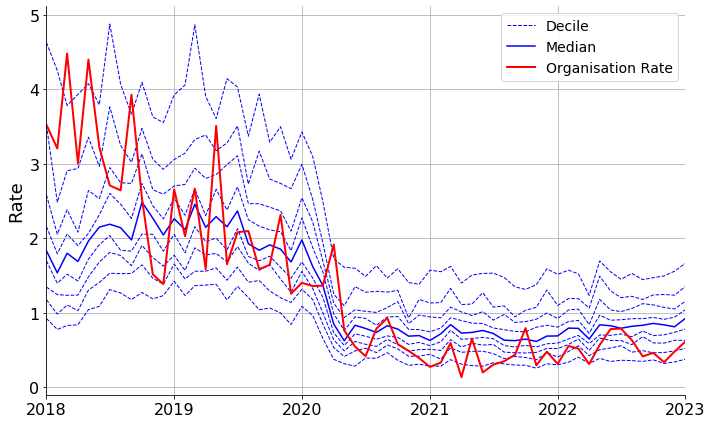

<h2 id=lptrimipramine><a href=https://openprescribing.net/measure/lptrimipramine>NHS England Low Priority Treatment - trimipramine</a></h2>

apply_rate_decrease_filter - Before: 106, After: 103
---------
apply_mean_events_filter - Before: 103, After: 103
---------
apply_zero_filter - Before: 103, After: 101
---------
apply_start_end_percentile_filter - Before: 101, After: 3
---------


<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/04Y>NHS CANNOCK CHASE</a></h4>

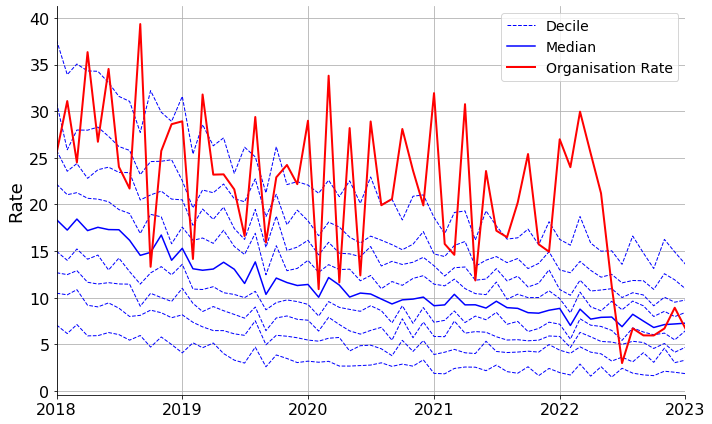

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/05G>NHS NORTH STAFFORDSHIRE</a></h4>

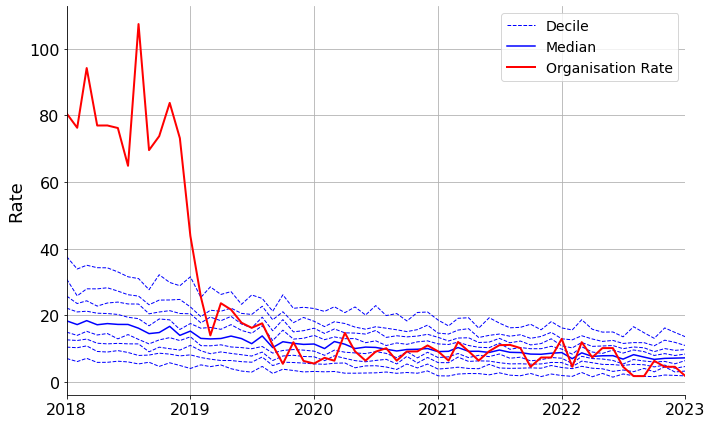

<h4><a href=https://openprescribing.net/measure/lptrimipramine/sicbl/00V>NHS BURY</a></h4>

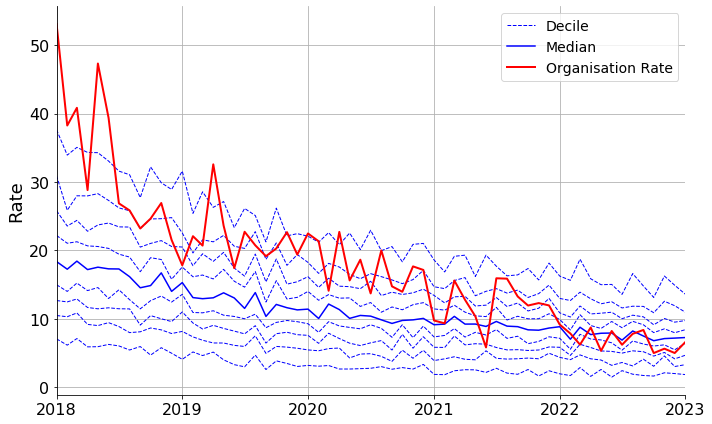

<h2 id=lpzomnibus><a href=https://openprescribing.net/measure/lpzomnibus>NHS England Low Priority Treatment - All Low Priority Treatments</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 2
---------


<h4><a href=https://openprescribing.net/measure/lpzomnibus/sicbl/99E>NHS BASILDON AND BRENTWOOD</a></h4>

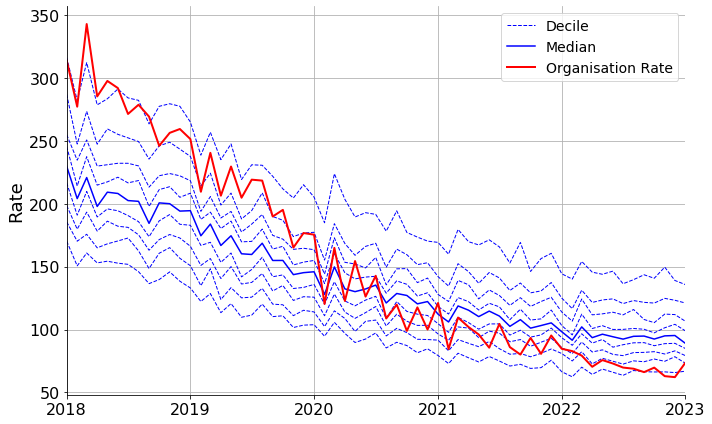

<h4><a href=https://openprescribing.net/measure/lpzomnibus/sicbl/02P>NHS BARNSLEY</a></h4>

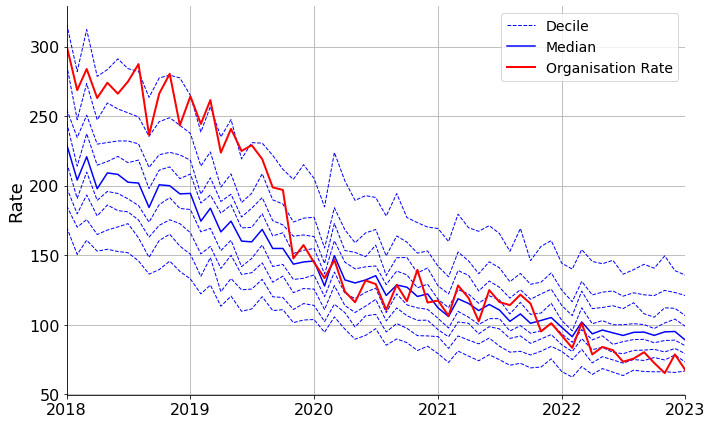

<h2 id=lyrica><a href=https://openprescribing.net/measure/lyrica>Pregabalin capsules prescribed as Lyrica</a></h2>

apply_rate_decrease_filter - Before: 106, After: 105
---------
apply_mean_events_filter - Before: 105, After: 105
---------
apply_zero_filter - Before: 105, After: 105
---------
apply_start_end_percentile_filter - Before: 105, After: 4
---------


<h4><a href=https://openprescribing.net/measure/lyrica/sicbl/10R>NHS PORTSMOUTH</a></h4>

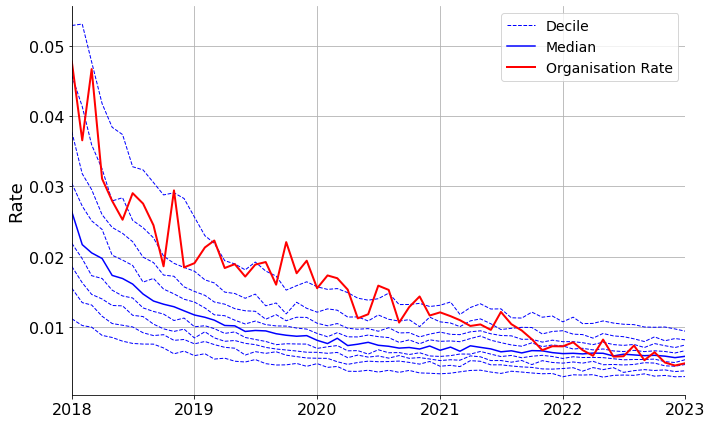

<h4><a href=https://openprescribing.net/measure/lyrica/sicbl/D2P2L>NHS BLACK COUNTRY AND WEST BIRMINGHAM</a></h4>

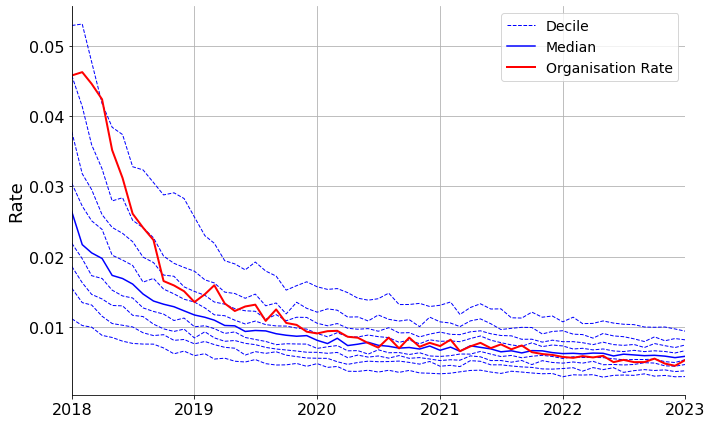

<h4><a href=https://openprescribing.net/measure/lyrica/sicbl/01H>NHS NORTH CUMBRIA</a></h4>

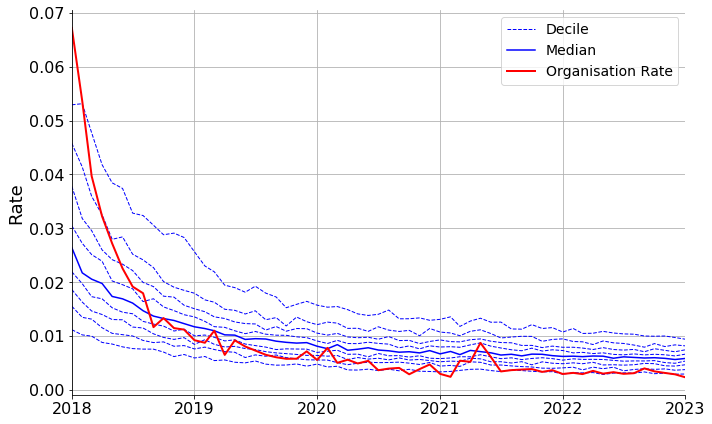

<h4><a href=https://openprescribing.net/measure/lyrica/sicbl/02G>NHS WEST LANCASHIRE</a></h4>

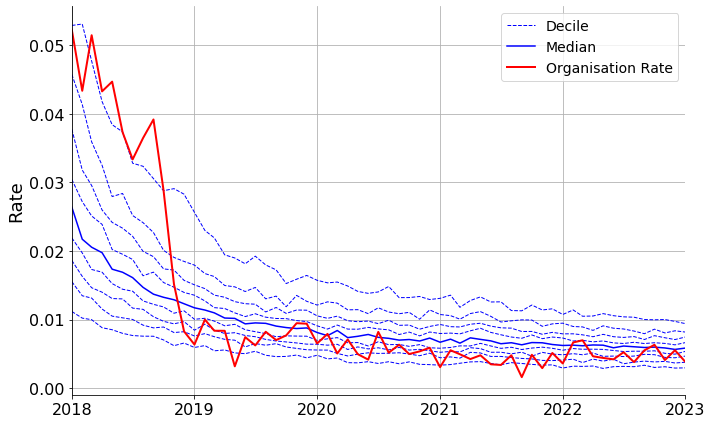

<h2 id=methotrexate><a href=https://openprescribing.net/measure/methotrexate>Methotrexate 10 mg tablets </a></h2>

apply_rate_decrease_filter - Before: 106, After: 93
---------
apply_mean_events_filter - Before: 93, After: 13
---------
apply_zero_filter - Before: 13, After: 13
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=nimodipine><a href=https://openprescribing.net/measure/nimodipine>Prescribing of nimodipine</a></h2>

apply_rate_decrease_filter - Before: 106, After: 36
---------
apply_mean_events_filter - Before: 36, After: 17
---------
apply_zero_filter - Before: 17, After: 12
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=opioidome><a href=https://openprescribing.net/measure/opioidome>Prescribing of opioids (total oral morphine equivalence)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 97
---------
apply_mean_events_filter - Before: 97, After: 97
---------
apply_zero_filter - Before: 97, After: 97
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=opioidper1000><a href=https://openprescribing.net/measure/opioidper1000>High dose opioids per 1000 patients</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 3
---------


<h4><a href=https://openprescribing.net/measure/opioidper1000/sicbl/99C>NHS NORTH TYNESIDE</a></h4>

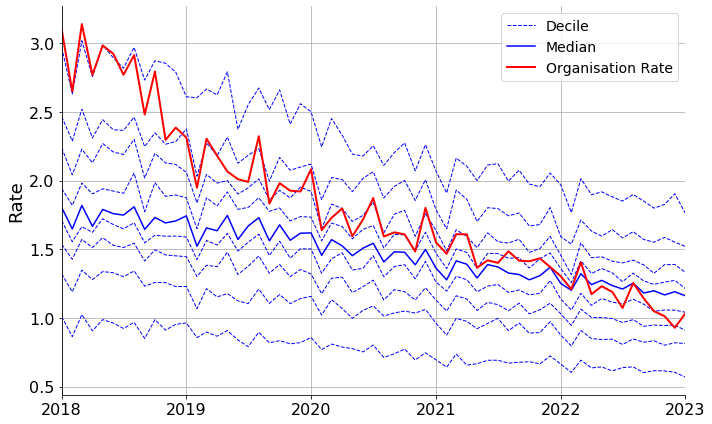

<h4><a href=https://openprescribing.net/measure/opioidper1000/sicbl/01G>NHS SALFORD</a></h4>

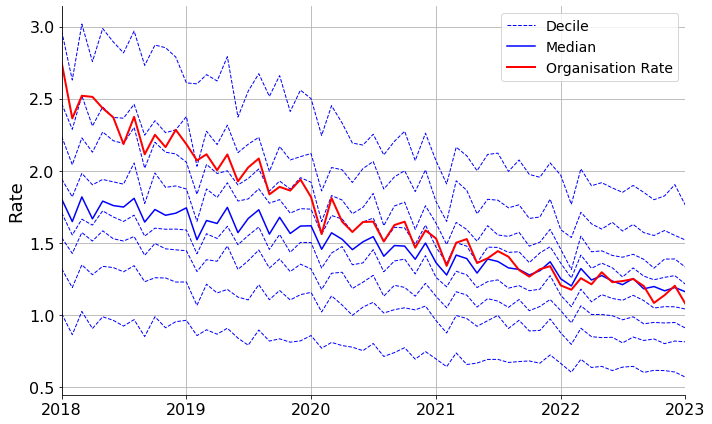

<h4><a href=https://openprescribing.net/measure/opioidper1000/sicbl/00N>NHS SOUTH TYNESIDE</a></h4>

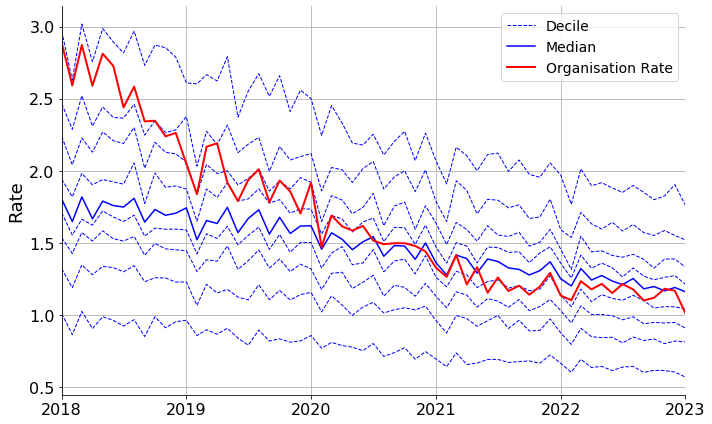

<h2 id=opioidspercent><a href=https://openprescribing.net/measure/opioidspercent>High dose opioid items as percentage regular opioids</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 1
---------


<h4><a href=https://openprescribing.net/measure/opioidspercent/sicbl/00N>NHS SOUTH TYNESIDE</a></h4>

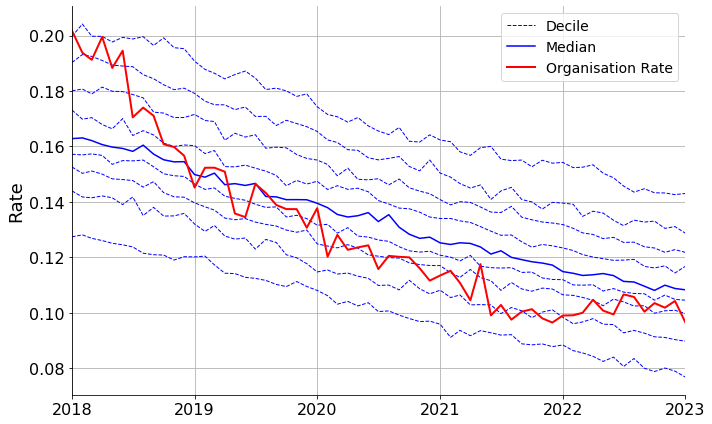

<h2 id=other_lipid_modifying_drugs><a href=https://openprescribing.net/measure/other_lipid_modifying_drugs>Other lipid-modifying drugs</a></h2>

apply_rate_decrease_filter - Before: 106, After: 7
---------
apply_mean_events_filter - Before: 7, After: 7
---------
apply_zero_filter - Before: 7, After: 7
---------
apply_start_end_percentile_filter - Before: 7, After: 1
---------


<h4><a href=https://openprescribing.net/measure/other_lipid_modifying_drugs/sicbl/06T>NHS NORTH EAST ESSEX</a></h4>

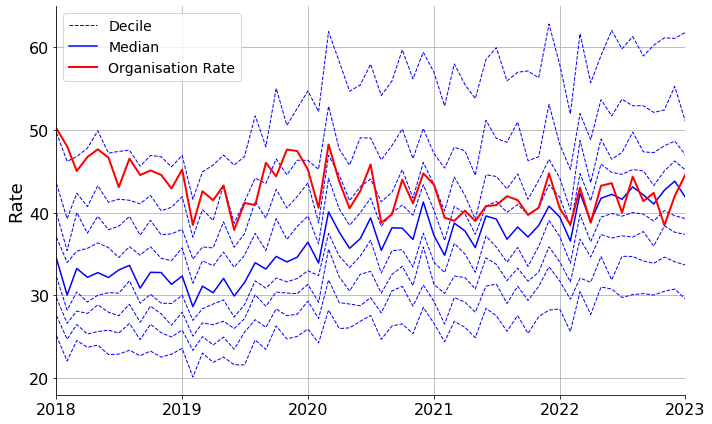

<h2 id=ppi><a href=https://openprescribing.net/measure/ppi>High-cost PPIs</a></h2>

apply_rate_decrease_filter - Before: 106, After: 70
---------
apply_mean_events_filter - Before: 70, After: 70
---------
apply_zero_filter - Before: 70, After: 70
---------
apply_start_end_percentile_filter - Before: 70, After: 2
---------


<h4><a href=https://openprescribing.net/measure/ppi/sicbl/03N>NHS SHEFFIELD</a></h4>

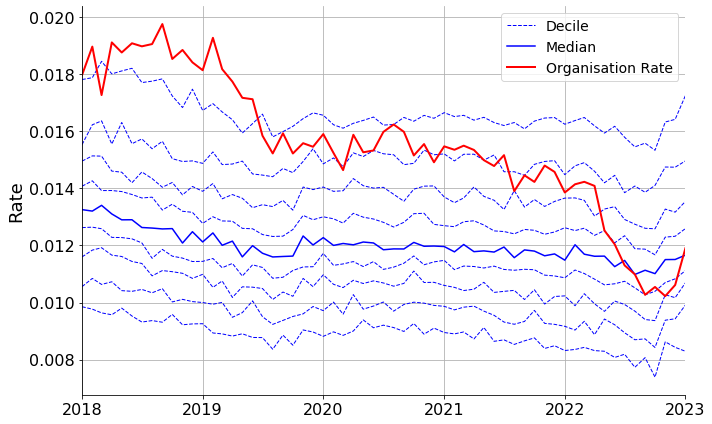

<h4><a href=https://openprescribing.net/measure/ppi/sicbl/03L>NHS ROTHERHAM</a></h4>

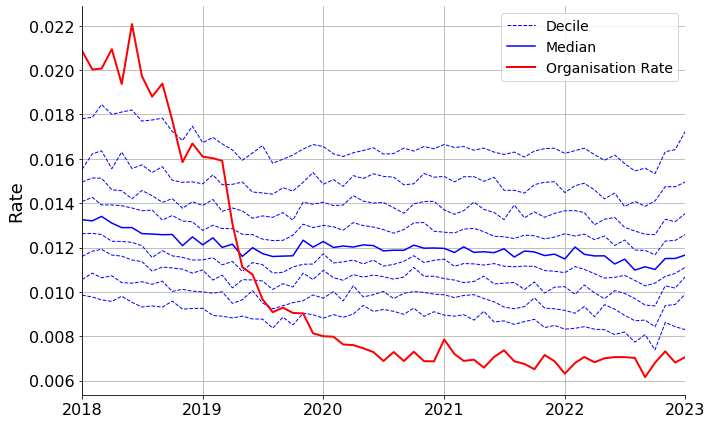

<h2 id=ppidose><a href=https://openprescribing.net/measure/ppidose>Higher dose Proton Pump Inhibitors (PPIs)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 14
---------
apply_mean_events_filter - Before: 14, After: 14
---------
apply_zero_filter - Before: 14, After: 14
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=pregabalinmg><a href=https://openprescribing.net/measure/pregabalinmg>Prescribing of pregabalin (total mg)</a></h2>

apply_rate_decrease_filter - Before: 106, After: 3
---------
apply_mean_events_filter - Before: 3, After: 3
---------
apply_zero_filter - Before: 3, After: 3
---------
apply_start_end_percentile_filter - Before: 3, After: 1
---------


<h4><a href=https://openprescribing.net/measure/pregabalinmg/sicbl/99C>NHS NORTH TYNESIDE</a></h4>

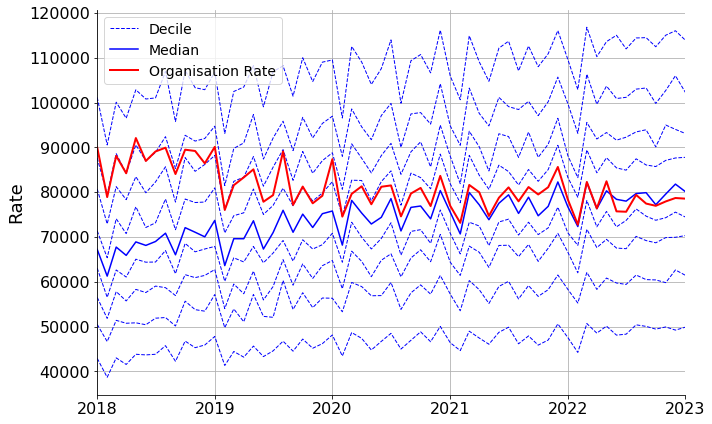

<h2 id=probiotics><a href=https://openprescribing.net/measure/probiotics>Probiotics that have been removed from the drug tariff</a></h2>

apply_rate_decrease_filter - Before: 106, After: 99
---------
apply_mean_events_filter - Before: 99, After: 90
---------
apply_zero_filter - Before: 90, After: 87
---------
apply_start_end_percentile_filter - Before: 87, After: 1
---------


<h4><a href=https://openprescribing.net/measure/probiotics/sicbl/03R>NHS WAKEFIELD</a></h4>

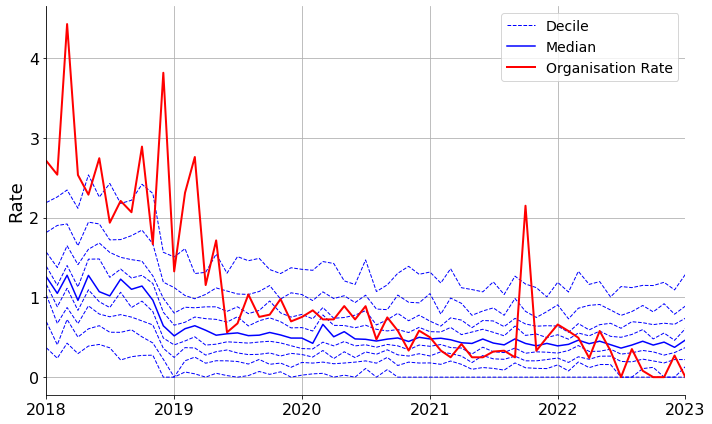

<h2 id=saba><a href=https://openprescribing.net/measure/saba>Short acting beta agonist inhalers</a></h2>

apply_rate_decrease_filter - Before: 106, After: 62
---------
apply_mean_events_filter - Before: 62, After: 62
---------
apply_zero_filter - Before: 62, After: 62
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=semagglutidequantity><a href=https://openprescribing.net/measure/semagglutidequantity>Possible excess quantities of semaglutide</a></h2>

After applying apply_rate_decrease_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=seven_day_prescribing><a href=https://openprescribing.net/measure/seven_day_prescribing>Seven Day Prescribing for Long Term Conditions</a></h2>

apply_rate_decrease_filter - Before: 106, After: 60
---------
apply_mean_events_filter - Before: 60, After: 60
---------
apply_zero_filter - Before: 60, After: 60
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=sildenafil><a href=https://openprescribing.net/measure/sildenafil>High-cost drugs for erectile dysfunction</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 105
---------
apply_zero_filter - Before: 105, After: 105
---------
apply_start_end_percentile_filter - Before: 105, After: 2
---------


<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/71E>NHS LINCOLNSHIRE</a></h4>

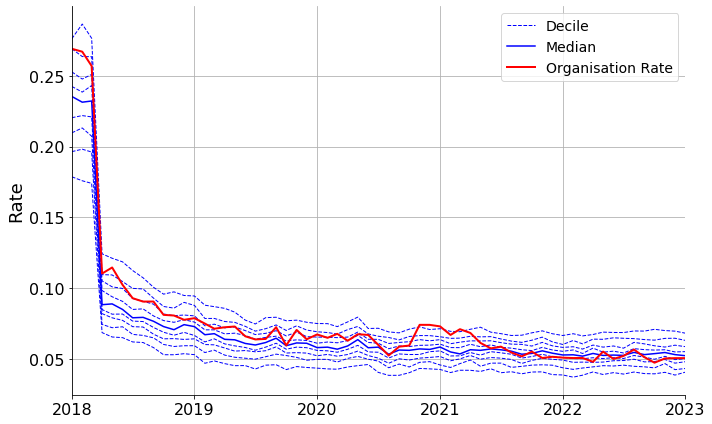

<h4><a href=https://openprescribing.net/measure/sildenafil/sicbl/01F>NHS HALTON</a></h4>

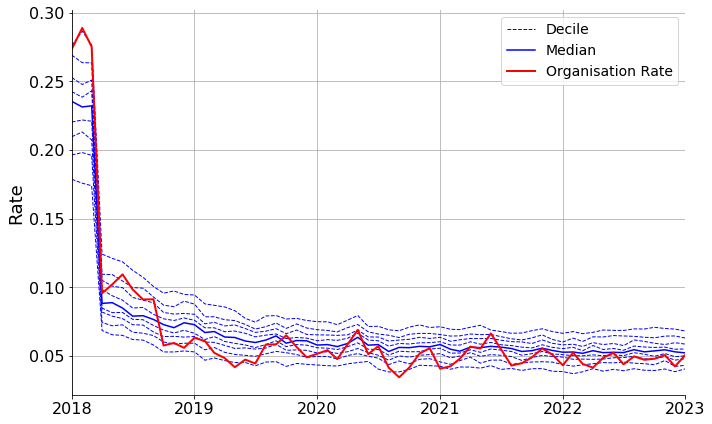

<h2 id=silver><a href=https://openprescribing.net/measure/silver>Silver dressings</a></h2>

apply_rate_decrease_filter - Before: 106, After: 31
---------
apply_mean_events_filter - Before: 31, After: 19
---------
apply_zero_filter - Before: 19, After: 19
---------
apply_start_end_percentile_filter - Before: 19, After: 1
---------


<h4><a href=https://openprescribing.net/measure/silver/sicbl/03N>NHS SHEFFIELD</a></h4>

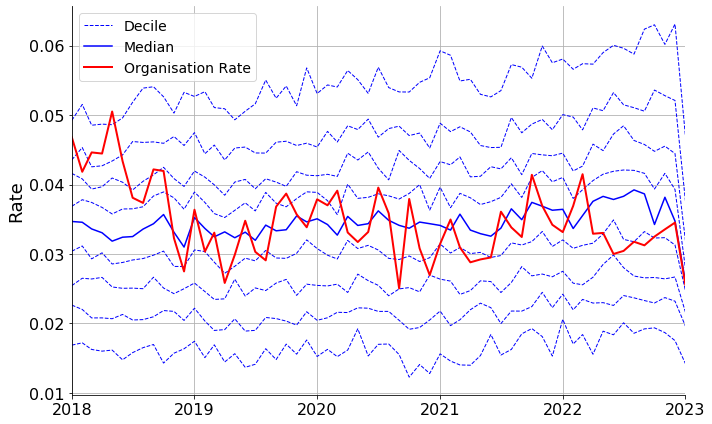

<h2 id=solublepara><a href=https://openprescribing.net/measure/solublepara>Soluble/effervescent forms of paracetamol and co-codamol</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 1
---------


<h4><a href=https://openprescribing.net/measure/solublepara/sicbl/11J>NHS DORSET</a></h4>

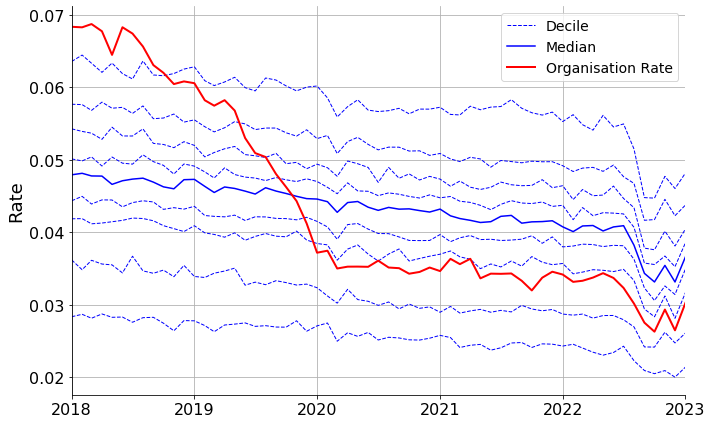

<h2 id=statinintensity><a href=https://openprescribing.net/measure/statinintensity>Low and medium intensity statins</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 1
---------


<h4><a href=https://openprescribing.net/measure/statinintensity/sicbl/11X>NHS SOMERSET</a></h4>

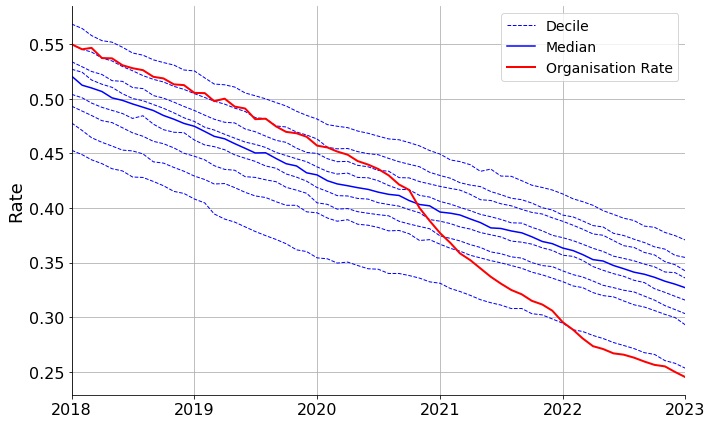

<h2 id=tamoxifen><a href=https://openprescribing.net/measure/tamoxifen>Prescribing of tamoxifen</a></h2>

apply_rate_decrease_filter - Before: 106, After: 89
---------
apply_mean_events_filter - Before: 89, After: 89
---------
apply_zero_filter - Before: 89, After: 89
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=toothpaste><a href=https://openprescribing.net/measure/toothpaste>Toothpaste Prescribing</a></h2>

apply_rate_decrease_filter - Before: 106, After: 35
---------
apply_mean_events_filter - Before: 35, After: 34
---------
apply_zero_filter - Before: 34, After: 34
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=tramadol><a href=https://openprescribing.net/measure/tramadol>Prescribing of high cost tramadol preparations </a></h2>

apply_rate_decrease_filter - Before: 106, After: 47
---------
apply_mean_events_filter - Before: 47, After: 47
---------
apply_zero_filter - Before: 47, After: 47
---------
After applying apply_start_end_percentile_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=trimethoprim><a href=https://openprescribing.net/measure/trimethoprim>Antibiotic stewardship: prescribing of trimethoprim vs nitrofurantoin</a></h2>

apply_rate_decrease_filter - Before: 106, After: 99
---------
apply_mean_events_filter - Before: 99, After: 99
---------
apply_zero_filter - Before: 99, After: 99
---------
apply_start_end_percentile_filter - Before: 99, After: 2
---------


<h4><a href=https://openprescribing.net/measure/trimethoprim/sicbl/00T>NHS BOLTON</a></h4>

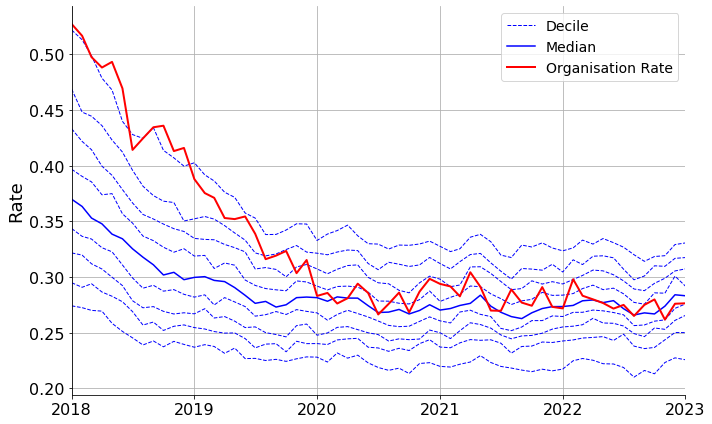

<h4><a href=https://openprescribing.net/measure/trimethoprim/sicbl/14L>NHS MANCHESTER</a></h4>

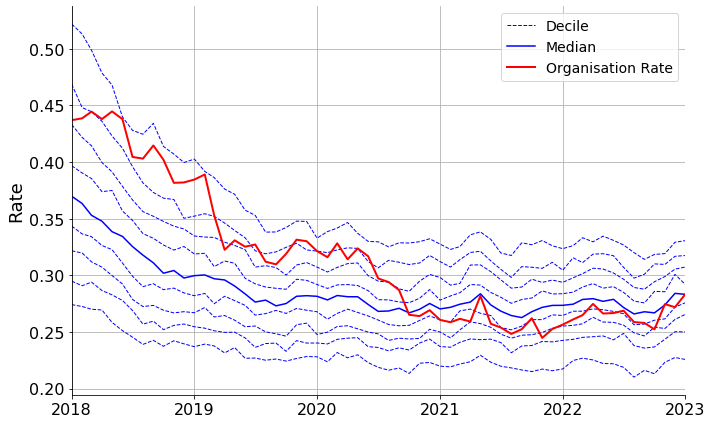

<h2 id=ulipristal><a href=https://openprescribing.net/measure/ulipristal>Ulipristal acetate 5mg prescribing for uterine fibroids</a></h2>

apply_rate_decrease_filter - Before: 106, After: 104
---------
After applying apply_mean_events_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

<h2 id=vitb><a href=https://openprescribing.net/measure/vitb>Vitamin B vs thiamine</a></h2>

apply_rate_decrease_filter - Before: 106, After: 106
---------
apply_mean_events_filter - Before: 106, After: 106
---------
apply_zero_filter - Before: 106, After: 106
---------
apply_start_end_percentile_filter - Before: 106, After: 2
---------


<h4><a href=https://openprescribing.net/measure/vitb/sicbl/06K>NHS EAST AND NORTH HERTFORDSHIRE</a></h4>

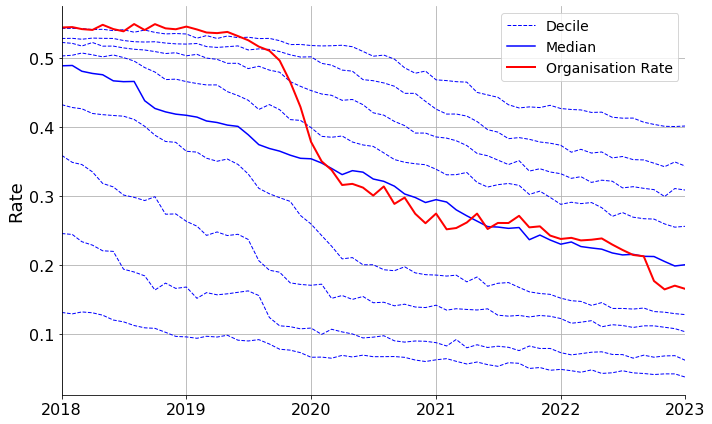

<h4><a href=https://openprescribing.net/measure/vitb/sicbl/06Q>NHS MID ESSEX</a></h4>

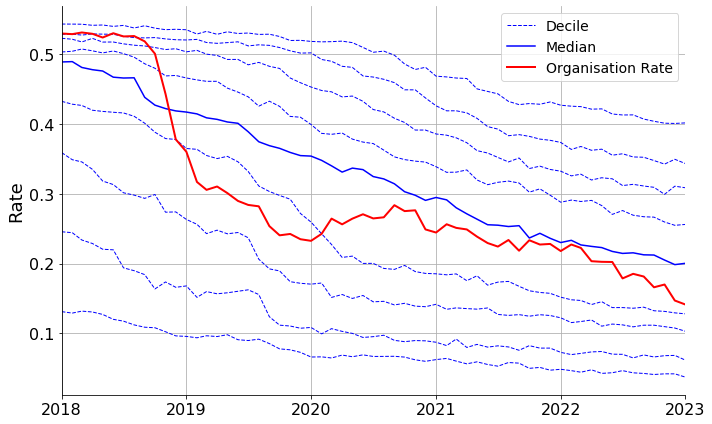

<h2 id=vitbper1000><a href=https://openprescribing.net/measure/vitbper1000>Vitamin B complex per 1000 patients</a></h2>

apply_rate_decrease_filter - Before: 106, After: 102
---------
apply_mean_events_filter - Before: 102, After: 102
---------
apply_zero_filter - Before: 102, After: 102
---------
apply_start_end_percentile_filter - Before: 102, After: 6
---------


<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01V>NHS SOUTHPORT AND FORMBY</a></h4>

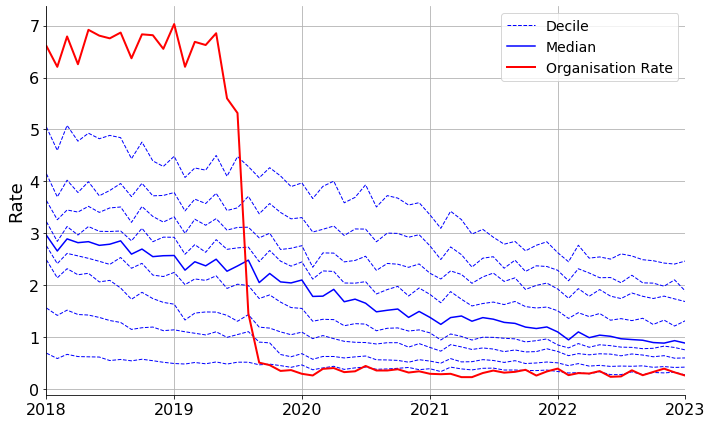

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01T>NHS SOUTH SEFTON</a></h4>

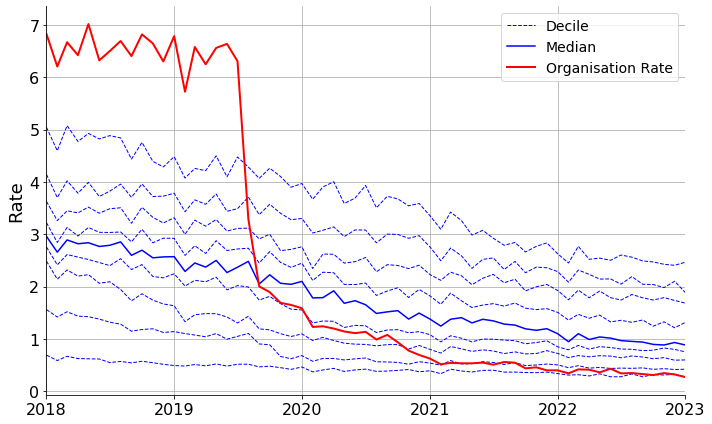

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/02P>NHS BARNSLEY</a></h4>

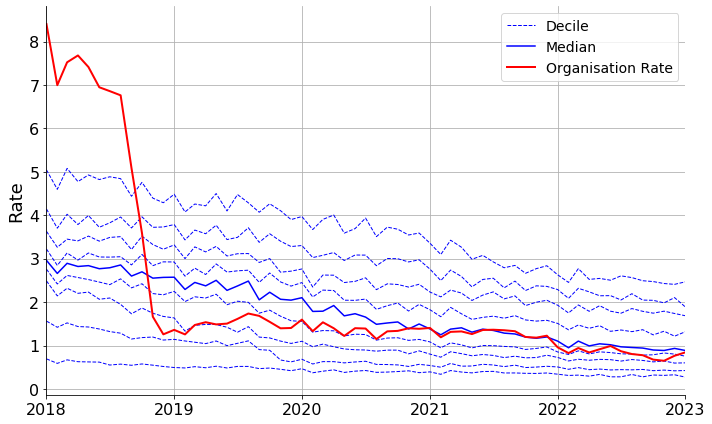

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01X>NHS ST HELENS</a></h4>

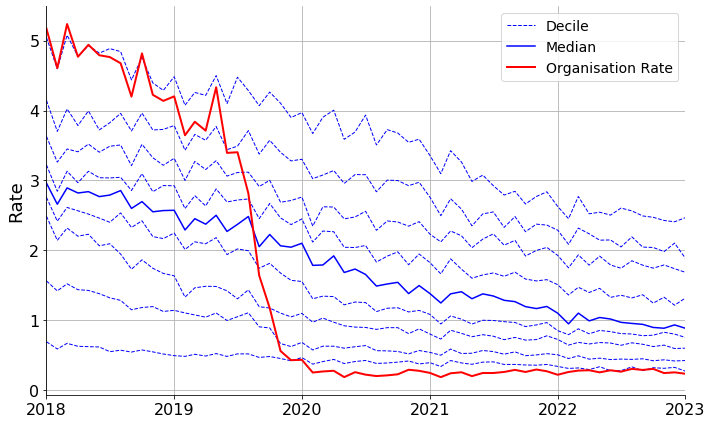

<h4><a href=https://openprescribing.net/measure/vitbper1000/sicbl/01J>NHS KNOWSLEY</a></h4>

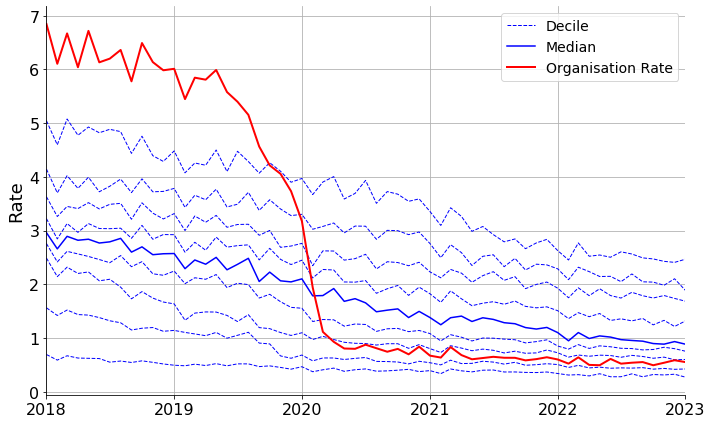

<h2 id=zuclopenthixol><a href=https://openprescribing.net/measure/zuclopenthixol>Zuclopenthixol acetate prescribing in primary care</a></h2>

apply_rate_decrease_filter - Before: 106, After: 19
---------
After applying apply_mean_events_filter, no organisations are left.


No organisations met the technical criteria for detecting substantial change on this measure.

In [99]:
display(Markdown('## Table of Contents'))

for m in measures:
    measure_link = f"https://openprescribing.net/measure/{m}"
    measure_description = measure_list.loc[measure_list["measure_name"] == m, "name"]
    if len(measure_description) > 0:
        measure_description=measure_description.iloc[0]
    
        display(Markdown(f'<a href=#{m}>- {measure_description}</a>'))
        
        
for m in measures:
    
    measure_link = f"https://openprescribing.net/measure/{m}"
    measure_description = measure_list.loc[measure_list["measure_name"] == m, "name"]
    if len(measure_description) > 0:
        measure_description=measure_description.iloc[0]
        
        display(Markdown(f'<h2 id={m}><a href={measure_link}>{measure_description}</a></h2>'))
        data = pd.read_csv(DATA_FOLDER / f'ccg_data_{m}/bq_cache.csv', parse_dates=["month"])
        data["rate"] = data["numerator"]/data["denominator"]

        data["percentile"] = data.groupby(["month"])["rate"].rank(pct=True)
    
        deciles = compute_deciles(data, "month", "rate")

        processor = DataFrameProcessor(data, config, verbose=config.get('show_filter_results', False))
        filtered_ccgs = processor.apply_combined_filters()


        num_orgs_identified = len(filtered_ccgs)
        # Main loop to plot CCG data
        if num_orgs_identified > 0:
#             display(Markdown(f"Number of organisations with improvement identified: {num_orgs_identified}"))
            for ccg in filtered_ccgs:
                sicbl_link = f"https://openprescribing.net/measure/{m}/sicbl/{ccg}"
                ccg_name = ccg_names.loc[ccg_names["code"]==ccg, "name"].values[0]
                display(Markdown(f'<h4><a href={sicbl_link}>{ccg_name}</a></h4>'))
                fig = plot_org_data(ccg, data, deciles)
                
             
        else:
            display(Markdown("No organisations met the technical criteria for detecting substantial change on this measure."))